In [1]:
%run 'config.ipynb'

config = Config({
    'tmp_folder' : '/var/shared/hist_project/Data/tmp',
    'data_folder' : '/var/shared/hist_project/Data',
    'level2_folder' : '/var/shared/hist_project/Data/Level2/0.6mpp',
    'frame_cache_file' : '/var/shared/hist_project/Data/tmp/generator-0.6mpp.cache',
    'tcga_clinical_csv' : '/var/shared/hist_project/Data/tmp/tcga_data_sep18_v2.csv',
    'tcga_brca_2012_pub_csv' : '/var/shared/hist_project/Data/tmp/TCGA_Supplementary Tables 1-4.csv',
    'tcga_brca_2018_csv' : '/var/shared/hist_project/Data/tmp/data_bcr_clinical_data_patient.csv',
    'tcga_grade_csv' : '/var/shared/hist_project/Data/tmp/tcga_grade.csv',
    'train_test_split_file' : '/var/shared/hist_project/Data/tmp/train_test_er_pr_full_her2fish_her2ihcscore_dx.split',
    'include_dx':True,
    'reinhard_dict_file' : '/var/shared/hist_project/Data/tmp/reinhard_norm.dict',
    'logs_dir':'/var/shared/hist_project/Data/logs'})

print(config)
print("\nNote: if you change the config file you need to restart the notebook for it to take effect")

Config:
train_test_split_file	/var/shared/hist_project/Data/tmp/train_test_er_pr_full_her2fish_her2ihcscore_dx.split
data_folder	/var/shared/hist_project/Data
tcga_clinical_csv	/var/shared/hist_project/Data/tmp/tcga_data_sep18_v2.csv
tcga_grade_csv	/var/shared/hist_project/Data/tmp/tcga_grade.csv
frame_cache_file	/var/shared/hist_project/Data/tmp/generator-0.6mpp.cache
reinhard_dict_file	/var/shared/hist_project/Data/tmp/reinhard_norm.dict
logs_dir	/var/shared/hist_project/Data/logs
tmp_folder	/var/shared/hist_project/Data/tmp
tcga_brca_2012_pub_csv	/var/shared/hist_project/Data/tmp/TCGA_Supplementary Tables 1-4.csv
include_dx	True
level2_folder	/var/shared/hist_project/Data/Level2/0.6mpp
tcga_brca_2018_csv	/var/shared/hist_project/Data/tmp/data_bcr_clinical_data_patient.csv

Note: if you change the config file you need to restart the notebook for it to take effect


In [2]:
%run 'ImageReader.ipynb'

print 'ImageReader loaded, use ImageReader.open(path, type=png\tiff), FrameCountCache(reader_list).dict'

ImageReader loaded, use ImageReader.open(path, type=png	iff), FrameCountCache(reader_list).dict


Make sure GPU is availble
-------------------------

(Should run with no errors)

In [3]:
import tensorflow as tf
import keras
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
    tf.nn.softmax(c, axis=1)

with tf.Session() as sess:
    print (sess.run(c))


Using TensorFlow backend.


[[22. 28.]
 [49. 64.]]


In [4]:
"""Load csv metadata into variable"""

import pandas as pd
def load_metadata_from_csv(csv_path, index_col=None, sep='\t'):
    xl = pd.read_csv(csv_path, sep, index_col=index_col) # Note
    return xl

csv_path = config.tcga_clinical_csv
metadata_all = load_metadata_from_csv(csv_path,index_col=0)
#metadata_all = metadata_all.filter(['Barcode','Cancer_type'])

In [5]:
print metadata_all.shape
metadata_all.head(n=5)

(9515, 16)


,Barcode,Cancer_type,PrimarySite,Diagnoses,Demographic,Age_At_Diagnosis,Days_To_Death,Ethnicity,Gender,Morphology,Tissue_Organ_Of_Origin,Tumor_Grade,Tumor_Stage,Vital_Status,Year_Of_Birth,Year_Of_Death
0,TCGA-E8-A2EA,THCA,Thyroid,"[{""classification_of_tumor"": ""not reported"", ""...","{""updated_datetime"": ""2018-03-07T12:25:31.5443...",19159.0,NaN,not hispanic or latino,female,8260/3,C73.9,not reported,stage i,alive,1959.0,NaN
1,TCGA-DK-AA6L,BLCA,Bladder,"[{""classification_of_tumor"": ""not reported"", ""...","{""updated_datetime"": ""2018-03-06T15:53:35.3116...",17635.0,1163.0,not hispanic or latino,male,8120/3,C67.1,not reported,stage iv,dead,1962.0,2013.0
2,TCGA-E2-A1AZ,BRCA,Breast,"[{""classification_of_tumor"": ""not reported"", ""...","{""updated_datetime"": ""2018-03-09T13:32:08.0652...",23230.0,NaN,hispanic or latino,female,8500/3,C50.9,not reported,stage iib,alive,1941.0,NaN
3,TCGA-AG-4021,READ,Colorectal,"[{""classification_of_tumor"": ""not reported"", ""...","{""updated_datetime"": ""2018-03-06T11:22:54.1356...",31015.0,121.0,not reported,female,8140/3,C20.9,not reported,stage iv,dead,1921.0,NaN
4,TCGA-DH-A7US,LGG,Brain,"[{""classification_of_tumor"": ""not reported"", ""...","{""updated_datetime"": ""2018-03-08T14:00:12.3409...",18429.0,NaN,not hispanic or latino,male,9450/3,C71.0,not reported,not reported,alive,1963.0,NaN


In [6]:
def findnth(haystack, needle, n):
    """Find Nth occurance of string in another string"""
    parts= haystack.split(needle, n+1)
    if len(parts)<=n+1:
        return -1
    return len(haystack)-len(parts[-1])-len(needle)

def breast_meta():
    breast_meta = load_metadata_from_csv(config.tcga_brca_2012_pub_csv,sep=',')
    breast_meta = breast_meta.filter(['Barcode', 'ER_Status', 'PR_Status', 'HER2_Final_Status', 'Tumor', 'Converted Stage'])
    return breast_meta
def breast_meta_2018():
    def create_her2_final_status(her2_ihc, her2_fish, her2_ihc_score):
        assert len(her2_ihc) == len(her2_fish) == len(her2_ihc_score)
        her2_final_status = []
        valid_vals = set(["Positive","Negative","Equivocal", "Indeterminate"])
        for ihc, ihc_score, fish in zip(her2_ihc, her2_ihc_score, her2_fish):
            if ihc_score in ["0","1"]:
                ihc_new = "Negative"
            elif ihc_score == "2":
                ihc_new = "Equivocal"
            elif ihc_score == "3":
                ihc_new = "Positive"
            else:
                ihc_new = 'UNK'
            if ihc == "Indeterminate":
                ihc = "Equivocal"
            her2_final_status.append(ihc_new)
        return her2_final_status
    breast_meta = load_metadata_from_csv(config.tcga_brca_2018_csv,sep='\t')
    selected_cols = [c for c in list(breast_meta.columns) if ('fish' in c.lower() or 'ihc' in c.lower()) or c=='Patient Identifier']
    selected_cols = [c for c in selected_cols if 'nte' not in c.lower() ]#and 'percent' not in c.lower() and 'score' not in c.lower() and 'Micromet' not in c]
    breast_meta = breast_meta[4:]
    breast_meta = breast_meta.filter(selected_cols)
    breast_meta = breast_meta.rename(index=str, columns={"Patient Identifier":"Barcode",
                                                         "ER Status By IHC": "ER_Status", 
                                                         "IHC-HER2" : "HER2_IHC", 
                                                         "HER2 fish status": "HER2_Fish",
                                                         "HER2 ihc score": "HER2_ihc_score",
                                                         "PR status by ihc": "PR_Status"})
    breast_meta = breast_meta.assign(HER2_IHC_SCORE_FINAL=\
                                     pd.Series(create_her2_final_status(
         list(breast_meta.HER2_IHC),list(breast_meta.HER2_Fish), list(breast_meta.HER2_ihc_score))).values
                                     )
    breast_meta = breast_meta.filter(["Barcode", "ER_Status", "PR_Status", "HER2_Fish", "HER2_ihc_score","HER2_IHC_SCORE_FINAL", "HER2_IHC"])
    return breast_meta
def breast_er(df):
    breast_dict = {row.Barcode: row.ER_Status for i, row in df.iterrows()}
    return breast_dict
def breast_her2(df, col_name):
    breast_dict = {row.Barcode: row[col_name] for i, row in df.iterrows()}
    return breast_dict
def breast_pr(df):
    breast_dict = {row.Barcode: row.PR_Status for i, row in df.iterrows()}
    return breast_dict

def grade_meta():
    grade_meta = load_metadata_from_csv(config.tcga_grade_csv, index_col=0)
    grade_dict = {row.Barcode: row.Differentiated for i, row in grade_meta.iterrows()}
    return grade_dict

def make_sample_type_slide_df():
    import os
    unify_type_id = { # Tumor \ Normal
        '01' : 'Tumor',
        '02' : 'Tumor',
        '05' : 'Tumor',
        '06' : 'Tumor',
        '07' : 'Tumor',
        '11' : 'Normal'
    }
    sample_type_dict =  {
     '01': 'Primary Solid Tumor',
     '02': 'Recurrent Solid Tumor',
     '05': 'Additional - New Primary',
     '06': 'Metastatic',
     '07': 'Additional Metastatic',
     '11': 'Solid Tissue Normal'
    }
    grade_dict = grade_meta()
    breast_meta_df = breast_meta_2018() # NEW VERSION
    breast_er_dict = breast_er(breast_meta_df)
    breast_her2_fish_dict = breast_her2(breast_meta_df, 'HER2_Fish')
    breast_her2_ihc_dict = breast_her2(breast_meta_df, 'HER2_IHC')
    breast_her2_ihc_score_dict = breast_her2(breast_meta_df, 'HER2_IHC_SCORE_FINAL')
    breast_pr_dict = breast_pr(breast_meta_df)
    data_folder = config.level2_folder+'/TCGA'
    image_names = os.listdir(data_folder)
    frame_dict = FrameCountCache(config.frame_cache_file, [ImageReader.open(data_folder+'/'+img_name,type='png') for img_name in image_names]).dict
    res_dict = {}
    for i, img_name in enumerate(image_names):
        tcga_barcode = img_name[:findnth(img_name,'-',2)]
        sample_type_id = img_name[findnth(img_name,'-',2)+1:findnth(img_name,'-',3)][:2]
        n_frames = frame_dict[img_name]
        res_dict[i] = (img_name, 
                       tcga_barcode, 
                       unify_type_id[sample_type_id], 
                       'normal' if unify_type_id[sample_type_id]=='Normal' else grade_dict.get(tcga_barcode, 'UNK') if sample_type_id=='01' else 'UNK', 
                       breast_er_dict.get(tcga_barcode, 'UNK') if sample_type_id=='01' else 'UNK',
                       breast_her2_fish_dict.get(tcga_barcode, 'UNK') if sample_type_id=='01' else 'UNK',
                       breast_her2_ihc_dict.get(tcga_barcode, 'UNK') if sample_type_id=='01' else 'UNK',
                       breast_her2_ihc_score_dict.get(tcga_barcode, 'UNK') if sample_type_id=='01' else 'UNK',
                       breast_pr_dict.get(tcga_barcode, 'UNK') if sample_type_id=='01' else 'UNK',
                       n_frames)
    
    # Convert to dataframe
    return pd.DataFrame.from_dict(res_dict, columns=['Slide_name', 'Barcode', 'Sample_type', 'Differentiated', 'ER_Status','HER2_Fish','HER2_IHC','HER2_IHC_SCORE_FINAL', 'PR_Status', 'Frames'], orient='index')

slide_sample_type_df = make_sample_type_slide_df()
print slide_sample_type_df.count()
#slide_sample_type_df.to_csv('/var/shared/hist_project/Data/tmp/tcga-samples.csv', sep='\t')
slide_sample_type_df.head()

Slide_name              3096
Barcode                 3096
Sample_type             3096
Differentiated          3096
ER_Status               3096
HER2_Fish               3096
HER2_IHC                3096
HER2_IHC_SCORE_FINAL    3096
PR_Status               3096
Frames                  3096
dtype: int64


,Slide_name,Barcode,Sample_type,Differentiated,ER_Status,HER2_Fish,HER2_IHC,HER2_IHC_SCORE_FINAL,PR_Status,Frames
0,TCGA-E2-A1IU-01A-01-TSA.ba60c639-0f0b-4ccf-899...,TCGA-E2-A1IU,Tumor,UNK,Positive,[Not Available],Negative,UNK,Positive,800
1,TCGA-A8-A08T-01A-01-BS1.a4f425d3-222d-4ef0-96f...,TCGA-A8-A08T,Tumor,moderately,Positive,Positive,Positive,Equivocal,Positive,800
2,TCGA-D8-A1JN-01Z-00-DX1.3B02989C-CEA0-4EDD-A6D...,TCGA-D8-A1JN,Tumor,UNK,Positive,Negative,Indeterminate,UNK,Positive,800
3,TCGA-GI-A2C9-01Z-00-DX1.90181423-51ED-41FE-9B8...,TCGA-GI-A2C9,Tumor,poorly,Negative,[Not Available],Negative,UNK,Negative,800
4,TCGA-AN-A04C-01A-01-BS1.4f8165fd-0791-4fa6-97e...,TCGA-AN-A04C,Tumor,UNK,Negative,[Not Available],Positive,Positive,Negative,800


In [7]:
import random

problem_cols = [#'PrimarySite', 
                #'Sample_type',
                'ER_Status',
                #'HER2_Fish',
                #'HER2_IHC',
                #'HER2_IHC_SCORE_FINAL',
                #'PR_Status', 
                #'Cancer_type'
               ]#, 'Differentiated']
problem_cols.sort() # Consistent order!

print problem_cols

# join sample type & tissue type
meta_join = slide_sample_type_df \
    .merge(metadata_all, on='Barcode') \
    .fillna('UNK') \

#grade_sites = set(['Breast', 'Head and Neck'])
er_sites = set(['Breast'])
cancer_types = set(['LUSC', 'READ', 'KIRP', 'GBM', 'LGG', 'LUAD', 'COAD', 'KIRC'])
sample_cancers = set(['COAD', 'LUSC', 'LIHC', 'BRCA', 'STAD', 'PRAD', 'LUAD', 'KIRC', 'THCA', 'OV', 'KIRP'])

meta_join.loc[meta_join.query("ER_Status not in ('Positive','Negative')").index,'ER_Status'] = 'UNK'
meta_join.loc[meta_join.query("HER2_Fish not in ('Positive','Negative')").index,'HER2_Fish'] = 'UNK'
meta_join.loc[meta_join.query("HER2_IHC not in ('Positive','Negative')").index,'HER2_IHC'] = 'UNK'
meta_join.loc[meta_join.query("HER2_IHC_SCORE_FINAL not in ('Positive','Negative')").index,'HER2_IHC_SCORE_FINAL'] = 'UNK'
meta_join.loc[meta_join.query("PR_Status not in ('Positive','Negative')").index,'PR_Status'] = 'UNK'

meta_join.loc[~meta_join.PrimarySite.isin(er_sites), 'ER_Status'] = 'UNK'
meta_join.loc[~meta_join.Cancer_type.isin(sample_cancers), 'Sample_type'] = 'UNK'
meta_join.loc[meta_join.Sample_type=='Normal', 'Cancer_type'] = 'UNK'
meta_join.loc[~meta_join.Cancer_type.isin(cancer_types), 'Cancer_type'] = 'UNK'

#print meta_join['Cancer_type'].unique(), len(meta_join['Cancer_type'].unique())

# Filter breast only
meta_join = meta_join.loc[meta_join.PrimarySite.isin(er_sites)]

meta_join = meta_join.filter(['Slide_name','Barcode','Frames'] + problem_cols)

print len(meta_join)
meta_join.head()

['ER_Status']
3096


,Slide_name,Barcode,Frames,ER_Status
0,TCGA-E2-A1IU-01A-01-TSA.ba60c639-0f0b-4ccf-899...,TCGA-E2-A1IU,800,Positive
1,TCGA-E2-A1IU-11A-01-TSA.1c0aabbc-d315-4571-ada...,TCGA-E2-A1IU,100,UNK
2,TCGA-E2-A1IU-01Z-00-DX1.E2F24814-24BA-4158-884...,TCGA-E2-A1IU,800,Positive
3,TCGA-E2-A1IU-11A-02-TSB.b1e1d4f0-7a97-4a67-a15...,TCGA-E2-A1IU,383,UNK
4,TCGA-E2-A1IU-11A-03-TSC.1e0a5cc1-d90d-4b19-9f9...,TCGA-E2-A1IU,242,UNK


In [8]:
from collections import Counter

def hash_dict(my_dict):
    return frozenset(my_dict)

def prepare_labels(meta_join, problem_cols):
    """Make dictionary[patients] , where patient is dictionary[filename]=file_labels"""
    labels = {}
    for i, row in meta_join.iterrows():
        filename = row['Slide_name']
        #if '-DX' in filename:
        #    continue
        tcga_barcode = filename[:findnth(filename,'-',2)]
        dct = labels.get(tcga_barcode,{})
        dct[filename] = tuple([row[prob_col] for prob_col in problem_cols])
        labels[tcga_barcode] = dct
    return labels

labels_dict = prepare_labels(meta_join, problem_cols)

#Show sample of labels
labels_sample = {slide_name: labels_dict[slide_name] for slide_name in labels_dict.keys()[:8]}
print labels_sample

#Show patients with most slides
slide_counter = Counter()
for k,lst in labels_dict.iteritems():
    slide_counter.update([k]*len(lst))
labels_sample_top = slide_counter.most_common(4)
print labels_sample_top

{'TCGA-E9-A2JT': {'TCGA-E9-A2JT-01A-02-TSB.7607FF14-463C-439C-AB91-0691679D0045': ('UNK',), 'TCGA-E9-A2JT-01Z-00-DX1.49C2B936-3B1A-4014-8B43-26D483DEF53A': ('UNK',)}, 'TCGA-BH-A0W4': {'TCGA-BH-A0W4-01A-01-BSA.010d7af0-073a-48aa-a257-10583b33c6f7': ('Positive',), 'TCGA-BH-A0W4-01A-01-TSA.f592ae5d-5e10-4502-ba88-cea79f42f77e': ('Positive',), 'TCGA-BH-A0W4-01Z-00-DX1.23E017DC-15CB-4838-AC91-CFB11B932AB0': ('Positive',)}, 'TCGA-BH-A28Q': {'TCGA-BH-A28Q-01A-01-TSA.c1c6f077-05eb-435f-a8ed-ebb79bcba2cf': ('Positive',), 'TCGA-BH-A28Q-01Z-00-DX1.C6D1CA93-6B2A-4722-9270-5D56592D833D': ('Positive',)}, 'TCGA-AC-A3TM': {'TCGA-AC-A3TM-01Z-00-DX1.4421EE37-A2CC-4638-AC44-9C26CB09FDC1': ('Positive',), 'TCGA-AC-A3TM-01A-01-TSA.F95FDB50-245E-4B62-B328-009B57AA8750': ('Positive',)}, 'TCGA-E9-A2JS': {'TCGA-E9-A2JS-01Z-00-DX1.445BA2F8-3A4A-49D2-8D41-4ACFD32F2074': ('UNK',), 'TCGA-E9-A2JS-01A-01-TSA.8C89FED2-C22D-4C19-990B-22FD44EC8AEB': ('UNK',)}, 'TCGA-BH-A0B5': {'TCGA-BH-A0B5-11A-02-TSB.ede1fe0f-7b4b-42b7

In [9]:
flatten = lambda l: [item for sublist in l for item in sublist]


def find_file_recursive(folder, file_ext='*.svs'):
    import fnmatch
    import os

    matches = []
    for root, dirnames, filenames in os.walk(folder):
        for filename in fnmatch.filter(filenames, file_ext):
            matches.append(os.path.join(root, filename))
    return matches

def findnth(haystack, needle, n):
    """Find Nth occurance of string in another string"""
    parts= haystack.split(needle, n+1)
    if len(parts)<=n+1:
        return -1
    return len(haystack)-len(parts[-1])-len(needle)

def prepare_data(level2_folder=config.level2_folder):
    import os
    groups = ['TCGA'] #os.listdir(level2_folder)
    data = {}
    img_files = [  ['%s/%s/%s' % (level2_folder,g,img) for img in os.listdir('%s/%s' % (level2_folder,g))] for g in groups ]
    img_files = flatten(img_files) # flatten all groups
    for full_filename in img_files:
        filename = os.path.basename(full_filename)
        #if '-DX' in filename:
        #    continue # skip diagnostic slides for now
        #if '-DX' not in filename:
        #    continue # keep only diagnostic slides
        tcga_barcode = filename[:findnth(filename,'-',2)]
        
        patient_slide_list = data.get(tcga_barcode, [])
        patient_slide_list.append(full_filename)
        data[tcga_barcode] = patient_slide_list
    return data

data = prepare_data()

#del data['TCGA-VG-A8LO'] # Ovary

# order labels by data order
import os
#labels = {tcga_barcode: [labels_dict[tcga_barcode][os.path.basename(filename)] for filename in filelist] for tcga_barcode, filelist in data.iteritems()}
labels = {tcga_barcode: [labels_dict[tcga_barcode][os.path.basename(filename)] for filename in filelist] for tcga_barcode, filelist in data.iteritems() if tcga_barcode in labels_dict}

#Show sample of data
data_sample = {barcode: (data[barcode],labels[barcode]) for barcode in data.keys()[100:100+1]}
print data_sample

print '\nPatient with 2 slides:\nTCGA-A2-A0EQ: %s' % str(data['TCGA-A2-A0EQ'])

{'TCGA-AR-A24O': (['/var/shared/hist_project/Data/Level2/0.6mpp/TCGA/TCGA-AR-A24O-01A-01-TSA.6b58d894-4123-4ed5-a5ce-0139287cfda1', '/var/shared/hist_project/Data/Level2/0.6mpp/TCGA/TCGA-AR-A24O-01Z-00-DX1.04EFBAC8-7A4A-4005-890C-5CC3E1C67DBD'], [('Positive',), ('Positive',)])}

Patient with 2 slides:
TCGA-A2-A0EQ: ['/var/shared/hist_project/Data/Level2/0.6mpp/TCGA/TCGA-A2-A0EQ-01A-01-BSA.fa7a323e-2939-4941-a56f-3b7352b16050', '/var/shared/hist_project/Data/Level2/0.6mpp/TCGA/TCGA-A2-A0EQ-01Z-00-DX1.5FCD8890-4594-4BE2-93B1-B8F698BFD2A0', '/var/shared/hist_project/Data/Level2/0.6mpp/TCGA/TCGA-A2-A0EQ-01A-01-TSA.c64d0ac8-9849-47c7-86e1-2e2037b02422']


In [10]:
labels_sample = {slide_name: labels[slide_name] for slide_name in labels.keys()[:8]}
print labels_sample

{'TCGA-E9-A2JT': [('UNK',), ('UNK',)], 'TCGA-BH-A28Q': [('Positive',), ('Positive',)], 'TCGA-AC-A3TM': [('Positive',), ('Positive',)], 'TCGA-E9-A2JS': [('UNK',), ('UNK',)], 'TCGA-A8-A07I': [('Positive',), ('Positive',), ('Positive',)], 'TCGA-A8-A07O': [('Negative',), ('Negative',), ('Negative',)], 'TCGA-AN-A0XL': [('Positive',), ('Positive',), ('Positive',)], 'TCGA-E9-A5FL': [('Negative',), ('Negative',)]}


In [11]:
# Count how many tcga barcodes are missing in each (labels & data)
from collections import Counter

label_codes = set(labels.keys())
data_codes = set(data.keys())
union_codes = label_codes & data_codes
data_count_by_labels = Counter(flatten([labels[barcode] for barcode in union_codes]))
missing_count_by_labels = Counter(flatten([labels[barcode] for barcode in (label_codes - union_codes)]))

print 'labels: %d' % (sum(data_count_by_labels.values()) + sum(missing_count_by_labels.values()))
print 'data barcodes: %d' % len(data_codes)
print 'union: %d' % len(union_codes)
print '\ntypes in data : %s\n' % str(data_count_by_labels)
print '\ntypes not in data : %s\n' % str(missing_count_by_labels)

labels: 3096
data barcodes: 1098
union: 1098

types in data : Counter({('Positive',): 2003, ('Negative',): 574, ('UNK',): 519})


types not in data : Counter()



In [12]:
import numpy as np
import pickle

def labels_to_ids(labels):
    # Make a constant dict, consistent across runs
    label_dicts = get_label_dicts()
    print label_dicts
    label_ids = [[tuple([l_dict[sub_label] for l_dict, sub_label in zip(label_dicts,slide_labels)]) for slide_labels in case_labels] for case_labels in labels]
    num_classes = tuple([len(l_dict)-1 for l_dict in label_dicts])
    return num_classes, np.array(label_ids)

def weights_to_ids(weights_dict, prob_cols):
    label_dicts = get_label_dicts()
    weights_ids_dict = {}
    for w,v in weights_dict.iteritems():
        if type(w) != frozenset:
            continue
        w_named_dict = dict(w)
        w_id = tuple([l_dict[w_named_dict[col]] for col, l_dict in zip(prob_cols, label_dicts)])
        weights_ids_dict[w_id] = v
    return weights_ids_dict

def get_label_dicts():
    # ORDER MATTERS IN RETURN STATEMENT
    #diff_dict = {'UNK':0, 'well': 1, 'moderately': 2, 'poorly': 3}
    er_dict = {'UNK':0, 'Positive':1, 'Negative': 2}
    site_label_dict = {'UNK':0, 'Bladder' : 1, 'Breast' : 2, 'Cervix' : 3, 'Colorectal' : 4, 'Brain' : 5, 'Head and Neck' : 6, 'Kidney' : 7, 'Liver' : 8, 'Lung' : 9, 'Ovary' : 10, 'Prostate' : 11, 'Skin' : 12, 'Stomach' : 13, 'Thyroid' : 14, 'Uterus' : 15}
    #site_label_dict = {'UNK':0, 'Bladder' : 1, 'Breast' : 2, 'Cervix' : 3, 'Colorectal' : 4, 'Brain' : 5, 'Head and Neck' : 6, 'Kidney' : 7, 'Liver' : 8, 'Lung' : 9, 'Uterus' : 10, 'Prostate' : 11, 'Skin' : 12, 'Stomach' : 13, 'Thyroid' : 14}
    sample_type_dict = {'UNK':0,'Normal': 1, 'Tumor' : 2}
    cancer_type_dict = {'UNK':0, 'LUSC': 1, 'READ' : 2, 'KIRP' : 3, 'GBM' : 4, 'LGG' : 5, 'LUAD' : 6, 'COAD':7, 'KIRC':8}
    return [er_dict] #[cancer_type_dict, er_dict, er_dict, er_dict,er_dict,er_dict, site_label_dict, sample_type_dict]

def shuffle(data, labels, weights=None):
    # Shuffle
    total_size = len(data)
    permutation = np.random.permutation(total_size)
    data = data[permutation]
    labels = labels[permutation]
    if weights is not None:
        weights = weights[permutation]
        return data, labels, weights
    return data, labels

def split_by_file(data_final, labels_final, split_file_path, flattened=True, include_dx=True):
    import pickle
    import os
    
    with open (split_file_path, 'rb') as f:
        split_dict = pickle.load(f)
    
    total_size = len(data_final)
    
    # Shuffle
    data_final, labels_final = shuffle(data_final, labels_final)
    
    # Split
    train_X, train_Y, val_X, val_Y = [], [], [], []
    added_barcodes = set()
    for file_path,file_label in zip(data_final, labels_final):
        file_name = os.path.basename(file_path)
        if not include_dx and '-DX' in file_name:
            continue
        if sum(file_label) == 0:
            continue # skip all 0
        tcga_barcode = file_name[:findnth(file_name,'-',2)]
        if tcga_barcode in split_dict['Train']:
            train_X.append(file_path)
            train_Y.append(file_label)
            added_barcodes.add(tcga_barcode)
        elif tcga_barcode in split_dict['Test']:
            val_X.append(file_path)
            val_Y.append(file_label)
            added_barcodes.add(tcga_barcode)
    print len(split_dict['Test']), len(added_barcodes & split_dict['Test'])
    print len(split_dict['Train']), len(added_barcodes & split_dict['Train'])
    train_dataset = np.array(train_X), np.array(train_Y)
    val_dataset = np.array(val_X), np.array(val_Y)
    
    train_dataset = shuffle(*train_dataset)
    val_dataset = shuffle(*val_dataset)
    
    return train_dataset, val_dataset

union_codes = list(set(labels.keys()) & set(data.keys()))
data_final = np.array([data[k] for k in union_codes])
num_classes, labels_final = labels_to_ids([labels[k] for k in union_codes])
labels_final = np.array(labels_final)
assert len(data_final) == len(labels_final)

#new
train_dataset, val_dataset = split_by_file(np.array(flatten(data_final)), np.array(flatten(labels_final)), 
                                           config.train_test_split_file,
                                           include_dx=config.include_dx)

from collections import Counter
#display(Counter(val_dataset[1]))
display(train_dataset[0][:3])
display(train_dataset[1][:3])
print 'train_size: %d, val_size: %d' % (len(train_dataset[0]), len(val_dataset[0]))
print 'num classes: ' + str(num_classes)

[{'Positive': 1, 'UNK': 0, 'Negative': 2}]
1190 91
8325 955


array(['/var/shared/hist_project/Data/Level2/0.6mpp/TCGA/TCGA-A2-A0YI-01Z-00-DX1.1CF2EC2D-C722-467F-8832-409B823E8D8F',
       '/var/shared/hist_project/Data/Level2/0.6mpp/TCGA/TCGA-AR-A1AY-01Z-00-DX1.6AC0BE3B-FFC5-4EDA-9E40-B18CAAC52B81',
       '/var/shared/hist_project/Data/Level2/0.6mpp/TCGA/TCGA-BH-A2L8-01A-01-TSA.BB86D75F-CD05-4200-A4B7-2D83C697D53A'],
      dtype='|S109')

array([[1],
       [2],
       [1]])

train_size: 2330, val_size: 247
num classes: (2,)


In [13]:
def to_categorical(Y, num_classes=num_classes):
    Y_np = np.array(Y)
    Y_np -= 1
    res = []
    for i,classes_dim in enumerate(num_classes):
        label_dim = Y_np[:,i]
        mask_idx = np.argwhere(label_dim==-1)
        label_dim = np.maximum(label_dim, 0)
        label_dim_one_hot = keras.utils.to_categorical(label_dim,num_classes=classes_dim)
        label_dim_one_hot[mask_idx] *= np.zeros(classes_dim)
        res.append(label_dim_one_hot)
    res_final = np.concatenate(res, axis=1)
    
    #print np.argwhere(res[0][0]>0), np.argwhere(res[1][0]>0)
    #print res[0].shape, res[1].shape
    #print res_final.shape
    return res_final

print to_categorical([ [1, 1, 1], ((2,15,2)) ], num_classes=(2,15,2))

[[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]]


In [14]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    chunks = []
    for i in range(0, len(l), n):
        sub_l = l[i:i + n]
        if len(sub_l) < n:
            sub_l = sub_l + l[:n-len(sub_l)]
        chunks.append(sub_l)
    return chunks

def chunks_repeat(l, n):
    import random
    lists = [l.copy() for __ in range(n)]
    for lis in lists:
        random.shuffle(lis)
    return list(zip(*lists))
    
def len_combinations(n, k):
    """a.k.a nCr"""
    import math
    f = math.factorial
    return f(n) / f(k) / f(n-k)

def random_combination(iterable, k):
    import random
    return tuple(sorted(random.sample(tuple(iterable), k)))

def random_combinations(iterable, p, k):
    import random
    import itertools
    pool = tuple(iterable)
    combs = list(itertools.combinations(pool, k))
    random.shuffle(combs)
    return combs[:p]

def random_combinations_efficient(iterable, p, k):
    import random
    import itertools
    
    num_combs = len_combinations(len(iterable), k)
    if num_combs < p:
        raise
    if num_combs < p*10:
        return random_combinations(iterable, p, k) # full
    
    combs = set([])
    while len(combs) < p:
        combs.add(tuple(sorted(random.sample(pool, k)))) # random combination
    
    return list(combs)

print chunks([1,2,3,4], 3)
print len_combinations(4, 2) # 6
print len_combinations(15, 3) # 6
print random_combinations(range(10), 5, 3)
print random_combination(range(50), 3)

#print chunks_repeat([1, 2, 3, 4], 3)

[[1, 2, 3], [4, 1, 2]]
6
455
[(0, 3, 4), (0, 5, 9), (2, 7, 9), (2, 4, 5), (1, 3, 6)]
(22, 36, 44)


In [15]:
def load_reinhard_dict():
    import pickle
    with open(config.reinhard_dict_file, 'rb') as f:
        return pickle.load(f)
        
reinhard_dict = load_reinhard_dict()

In [16]:
import PIL
import random
import os
from collections import Counter

#random.seed(None)
#np.random.seed(None)

class BatchGenerator(object):
    def __init__(self, (data, labels), batch_size, num_classes, eq_modes, norm_func, patches_per_img, 
                 image_data_generator=None, reinhard_dict=None,
                 to_shuffle=False, dummy_reset=True, should_augment_data=True, n_patches=3):
        
        #TODO: Ugly fix later
        data_tmp = np.array([ImageReader.open(d,type='png') for d in data])
        frames_dict = FrameCountCache(config.frame_cache_file, data_tmp).dict
        data = np.array([ImageReader.open(d,type='png', frame_cache_dict=frames_dict, reinhard_norm_dict=reinhard_dict) for d in data])
        
        self.image_data_generator = image_data_generator
        self.should_augment_data = should_augment_data
        self.batch_size = batch_size
        self.shuffle = to_shuffle
        self.is_dummy_reset = dummy_reset
        
        self.num_classes = num_classes
        self.n_patches = n_patches
        self.patches_per_img = patches_per_img
        
        self.normalize_input = norm_func
        
        self.initial_data = data, labels
        
        prepare_data_funcs = []
        for eq_mode in eq_modes:      
            if eq_mode == 'infer_weights':
                prepare_data_funcs.append(self.prepare_data_inferweights)
            elif eq_mode == 'eq_patches_by_slide':
                prepare_data_funcs.append(self.prepare_data_eq_patches_by_slide)
            elif eq_mode == 'eq_patches_by_slide_v2':
                prepare_data_funcs.append(self.prepare_data_eq_patches_by_slide_v2)
            elif eq_mode == 'eq_patches_by_patient_v5':
                prepare_data_funcs.append(self.prepare_data_eq_patches_by_patient_v5)
            elif eq_mode == 'eq_patches_by_patient_v2':
                prepare_data_funcs.append(self.prepare_data_eq_patches_by_patient_v2)
            elif eq_mode == 'eq_patches_by_label_v2':
                prepare_data_funcs.append(self.prepare_data_eq_patches_by_label_v2)
            else:
                raise Exception('Unknown eq mode')
        def prepare_data():
            data_all = [], [], []
            for func in prepare_data_funcs:
                data = func()
                assert len(data) == 3
                for i,d in enumerate(data):
                    data_all[i].append(d)
            
            self.data = np.concatenate(data_all[0]), np.concatenate(data_all[1]), np.concatenate(data_all[2])
            self.data = shuffle(self.data[0], self.data[1], self.data[2])
            
            self.num_examples = self.data[0].shape[0]

            self.batch_start = 0
                
        self.prepare_data = prepare_data
        self.prepare_data()
        
        print 'Generator: %d examples, %s classes' % (self.num_examples, str(self.num_classes))
    @staticmethod
    def infer_weights_from_bags(bags):
        from collections import Counter
        
        # assume bags keys are range(0, class_size)
        class_size = len(bags)
        bags_len = {y:len(x) for y,x in bags.iteritems()}
        
        most_common = max(bags_len.values())
        weights = [1.0*most_common/bags_len[y]  for y in range(class_size)]
        return weights
    def prepare_data_eq_patches_by_slide(self):
        """Equalize each problem seperately (by oversampling). Each patch will have label for one problem only"""
        import math
        def make_oneclass_label(yi, index, prob_count):
            return [(yi+1) if i==index else 0 for i in range(prob_count)]
        def mask_weight(y, index):
            return [1.0]*len(y) #[1.0 if yi!=0 and i==index else 0.0 for i, yi in enumerate(y)]
        
        data, labels = self.initial_data

        data, labels = shuffle(data, labels) # order matters here
        
        p = self.n_patches
        base_per_img = self.patches_per_img #170 #38
                
        X = []
        Y = []
        W = []

        for i, class_size in enumerate(self.num_classes):
            bags = {y:[] for y in range(class_size)}
            for img_reader,y in zip(data,labels):
                if y[i] == 0:
                    continue #Skip unks
                bags[y[i]-1].append( img_reader )
            w = BatchGenerator.infer_weights_from_bags(bags)
            
            p_frames_free_dict = [{img_reader.basename():np.random.permutation(img_reader.n_frames()) for img_reader in data} \
                                for __ in range(p)]

            for y_weight, yi in zip(w, range(class_size)):
                debt = y_weight * base_per_img * len(bags[yi]) # debt eq for all classes
                payable_amount = sum(len(p_frames_free_dict[0][x.basename()]) for x in bags[yi])
                
                if not payable_amount >= debt:
                    print payable_amount, debt
                assert payable_amount >= debt
                while debt > 0:
                    y_base_per_img = debt / len(bags[yi])
                    if y_base_per_img < 1:
                        y_base_per_img = math.ceil(y_base_per_img) # Edge case
                    y_base_per_img = int(y_base_per_img)
                    #print y_base_per_img, y_weight, len(bags[y])
                    #print 'y(%d), debt(%d)' % (y, debt) # DEBUGGING
                    for img_reader in bags[yi]:
                        img_name = img_reader.basename()
                        
                        n_patches = []
                        for frames_free_dict in p_frames_free_dict:
                            n_frames = len(frames_free_dict[img_name])
                            frames_to_take = min(n_frames,y_base_per_img)
                            frame_range = frames_free_dict[img_name][:frames_to_take]
                            frames_free_dict[img_name] = frames_free_dict[img_name][frames_to_take:]
                            n_patches.append(frame_range)
                        n_patches = [(img_reader, chunk) for chunk in zip(*n_patches)]
                        X.extend(n_patches)
                        
                        y = make_oneclass_label(yi, i, len(self.num_classes))
                        Y.extend([y] * (len(frame_range)))
                        W.extend([mask_weight(y, i)] * (len(frame_range)))
                        
                        assert len(X) == len(Y) == len(W)
                        assert len(n_patches) == len(frame_range)
                        
                        debt -= len(frame_range)
                
        print np.array(X).shape, to_categorical(Y, num_classes=self.num_classes).shape, np.array(W).shape
        
        return np.array(X), to_categorical(Y, num_classes=self.num_classes), np.array(W)
    def prepare_data_eq_patches_by_slide_v2(self):
        """Equalize each problem seperately (by oversampling). Each patch will have label for one problem only"""
        import math
        def make_oneclass_label(yi, index, prob_count):
            return [(yi+1) if i==index else 0 for i in range(prob_count)]
        def mask_weight(y, index):
            return [1.0]*len(y) #[1.0 if yi!=0 and i==index else 0.0 for i, yi in enumerate(y)]
        
        data, labels = self.initial_data

        data, labels = shuffle(data, labels) # order matters here
        
        p = self.n_patches
        base_per_img = 80/p*p
                
        X = []
        Y = []
        W = []

        for i, class_size in enumerate(self.num_classes):
            #if i != 1:
            #    continue
            bags = {y:[] for y in range(class_size)}
            for img_reader,y in zip(data,labels):
                if y[i] == 0:
                    continue #Skip unks
                bags[y[i]-1].append( img_reader )
            w = BatchGenerator.infer_weights_from_bags(bags)
            
            frames_free_dict = {img_reader.basename():np.random.permutation(img_reader.n_frames()) for img_reader in data}

            for y_weight, yi in zip(w, range(class_size)):
                debt = float(int(y_weight * base_per_img * len(bags[yi]))) # debt eq for all classes
                payable_amount = sum(len(frames_free_dict[x.basename()]) for x in bags[yi])
                
                assert payable_amount >= debt
                
                reader_to_frames = {}
                while debt > 0:
                    y_base_per_img = debt / len(bags[yi])
                    if y_base_per_img < 1:
                        y_base_per_img = math.ceil(y_base_per_img) # Edge case
                    #print y_base_per_img, y_weight, len(bags[y])
                    #print 'y(%d), debt(%d)' % (y, debt) # DEBUGGING
                    for img_reader in bags[yi]:
                        img_name = img_reader.basename()
                        n_frames = len(frames_free_dict[img_name])
                        frames_to_take = min(n_frames,int(y_base_per_img))
                        frame_range = frames_free_dict[img_name][:frames_to_take]
                        frames_free_dict[img_name] = frames_free_dict[img_name][frames_to_take:]
                        
                        if img_reader not in reader_to_frames:
                            reader_to_frames[img_reader] = []
                        reader_to_frames[img_reader].extend(frame_range)
                        
                        debt -= len(frame_range)
                
                group_reader = GroupReader(reader_to_frames.keys())
                group_frame_indexes = [group_reader.reader_indexes_to_new_indexes(img_reader, reader_indexes) for img_reader, reader_indexes in reader_to_frames.iteritems()]
                group_frame_indexes = flatten(group_frame_indexes)
                random.shuffle(group_frame_indexes)
                
                new_len = len(group_frame_indexes)/p*p
                n_patches = [(group_reader,chunk) for chunk in chunks(group_frame_indexes[:new_len], p)]
                X.extend(n_patches)
                        
                y = make_oneclass_label(yi, i, len(self.num_classes))
                Y.extend([y] * (new_len/p))
                W.extend([mask_weight(y, i)] * (new_len/p))
                
                assert len(X) == len(Y) == len(W)
                assert len(n_patches) == len(group_frame_indexes)/p
        
        return np.array(X), to_categorical(Y, num_classes=self.num_classes), np.array(W)
    
    def prepare_data_eq_patches_by_patient_v5(self):
        import math
        import random
        import itertools
        def make_oneclass_label(yi, index, prob_count):
            return [(yi+1) if i==index else 0 for i in range(prob_count)]
        def mask_weight(y, index):
            return [1.0]*len(y) #[1.0 if yi!=0 and i==index else 0.0 for i, yi in enumerate(y)]
        
        data, labels = self.initial_data

        data, labels = shuffle(data, labels) # order matters here
        
        p = self.n_patches
        #base_per_patient = 90
                
        X = []
        Y = []
        W = []

        for i, class_size in enumerate(self.num_classes):
            #if i not in (1,2,3,4,5):
            #    continue
            bags = {y:{} for y in range(class_size)}
            for img_reader,y in zip(data,labels):
                if y[i] == 0:
                    continue #Skip unks
                if img_reader.n_frames() < p:
                    continue # skip slides with very little frames
                patient_barcode = img_reader.barcode()
                key = y[i]-1
                if patient_barcode not in bags[key]:
                    bags[key][patient_barcode] = []
                bags[key][patient_barcode].append( img_reader )
            w = BatchGenerator.infer_weights_from_bags(bags)
            #print w

            base_per_patient = 200
            assert base_per_patient > 0
            
            for y_weight, yi in zip(w, range(class_size)):
                debt = float(int(y_weight * base_per_patient * len(bags[yi]))) # debt eq for all classes
                
                for patient_barcode, patient_slides in bags[yi].iteritems():
                    patient_dx_slides = [img_reader for img_reader in patient_slides if '-DX' in img_reader.basename()]
                    patient_no_dx_slides = [img_reader for img_reader in patient_slides if '-DX' not in img_reader.basename()]
                    if len(patient_dx_slides) > 0 and len(patient_no_dx_slides) > 0:
                        final_slide_division = [patient_dx_slides, patient_no_dx_slides]
                        final_debt = 1.0 * debt / 2
                    else:
                        final_slide_division = [patient_slides]
                        final_debt = debt
                    for patient_slide_group in final_slide_division:
                        patient_debt = 1.0 * final_debt / len(bags[yi])

                        #print y_base_per_patient, y_weight, len(bags[yi])
                        #print 'c(%d), y(%d), debt(%d), patient(%d)' % (i, yi, debt, y_base_per_patient) # DEBUGGING

                        if len(patient_slide_group) > int(patient_debt):
                            patient_slide_group = random.sample(patient_slide_group, int(patient_debt))

                        assert len(patient_slide_group) > 0 # payable_amount > 0
                        y_base_per_img = patient_debt / len(patient_slide_group)
                        final_img_base = y_base_per_img
                        #print final_img_base

                        for img_reader in patient_slide_group:
                            img_name = img_reader.basename()
                            #n_combs = len_combinations(img_reader.n_frames(), p)
                            n_frames = range(img_reader.n_frames())

                            n_patches = [(img_reader, random_combination(n_frames, p)) for __ in range(int(final_img_base)) ]

                            X.extend(n_patches)

                            y = make_oneclass_label(yi, i, len(self.num_classes))
                            Y.extend([y] * len(n_patches))
                            W.extend([mask_weight(y, i)] * len(n_patches))

                            assert len(X) == len(Y) == len(W)        

                            patient_debt -= len(n_patches)
                            debt -= len(n_patches)
                    #print patient_debt
                    #assert patient_debt < 1
                
                #print debt
                #assert debt < 1
                
                """
                group_reader = GroupReader(reader_to_frames.keys())
                group_frame_indexes = [group_reader.reader_indexes_to_new_indexes(img_reader, reader_indexes) for img_reader, reader_indexes in reader_to_frames.iteritems()]
                group_frame_indexes = flatten(group_frame_indexes)
                random.shuffle(group_frame_indexes)
                
                new_len = len(group_frame_indexes)/p*p
                n_patches = [(group_reader,chunk) for chunk in chunks(group_frame_indexes[:new_len], p)]
                
                X.extend(n_patches)

                y = make_oneclass_label(yi, i, len(self.num_classes))
                Y.extend([y] * (new_len/p))
                W.extend([mask_weight(y, i)] * (new_len/p))
                
                assert len(X) == len(Y) == len(W)
                assert len(n_patches) == len(group_frame_indexes)/p   
                
                for reader, frames in reader_to_frames.iteritems():
                    assert len(frames) >= p
                    n_patches = [(reader, chunk) for chunk in chunks(frames, p)]
                    
                    X.extend(n_patches)

                    y = make_oneclass_label(yi, i, len(self.num_classes))
                    Y.extend([y] * len(n_patches))
                    W.extend([mask_weight(y, i)] * len(n_patches))
                
                    assert len(X) == len(Y) == len(W)        
                """

        return np.array(X), to_categorical(Y, num_classes=self.num_classes), np.array(W)
    
    def prepare_data_eq_patches_by_patient_v2(self):
        """Equalize each problem seperately (by oversampling). Each patch will have label for one problem only"""
        import math
        def make_oneclass_label(yi, index, prob_count):
            return [(yi+1) if i==index else 0 for i in range(prob_count)]
        def mask_weight(y, index):
            return [1.0]*len(y) #[1.0 if yi!=0 and i==index else 0.0 for i, yi in enumerate(y)]
        
        data, labels = self.initial_data

        data, labels = shuffle(data, labels) # order matters here
        
        p = self.n_patches
        base_per_img = 125 / p
                
        X = []
        Y = []
        W = []

        for i, class_size in enumerate(self.num_classes):
            #if i != 1:
            #    continue
            bags = {y:{} for y in range(class_size)}
            for img_reader,y in zip(data,labels):
                if y[i] == 0:
                    continue #Skip unks
                patient_barcode = img_reader.barcode()
                key = y[i]-1
                if patient_barcode not in bags[key]:
                    bags[key][patient_barcode] = []
                bags[key][patient_barcode].append( img_reader )
            
            frames_free_dict = {}
            for key in bags.keys():
                for patient_barcode in bags[key].keys():
                    patient_image_readers = bags[key][patient_barcode]
                    patient_reader = PatientReader(patient_image_readers)
                    bags[key][patient_barcode] = patient_reader
                    frames_free_dict[(key, patient_reader.barcode())] = np.random.permutation(patient_reader.n_frames())
            w = BatchGenerator.infer_weights_from_bags(bags)
            
            for y_weight, yi in zip(w, range(class_size)):
                debt = float(int(p * y_weight * base_per_img * len(bags[yi]))) # debt eq for all classes
                payable_amount = sum(len(frames_free_dict[(yi, x.barcode())])/p*p for x in bags[yi].values())
                
                assert payable_amount >= debt
                while debt > 0:
                    y_base_per_img = debt / len(bags[yi]) / p
                    if y_base_per_img < 1:
                        y_base_per_img = math.ceil(y_base_per_img) # Edge case
                    #print y_base_per_img, y_weight, len(bags[y])
                    #print 'y(%d), debt(%d)' % (y, debt) # DEBUGGING
                    for patient_reader in bags[yi].values():
                        patient_barcode = patient_reader.barcode()
                        n_frames = len(frames_free_dict[(yi, patient_barcode)])
                        frames_to_take = min(n_frames/p,int(y_base_per_img)) * p
                        frame_range = frames_free_dict[(yi, patient_barcode)][:frames_to_take]
                        frames_free_dict[(yi, patient_barcode)] = frames_free_dict[(yi, patient_barcode)][frames_to_take:]
                        n_patches = [(patient_reader,chunk) for chunk in chunks(frame_range, p)]
                        X.extend(n_patches)
                        
                        y = make_oneclass_label(yi, i, len(self.num_classes))
                        Y.extend([y] * (len(frame_range)/p))
                        W.extend([mask_weight(y, i)] * (len(frame_range)/p))
                        
                        assert len(X) == len(Y) == len(W)
                        assert len(n_patches) == len(frame_range)/p

                        debt -= len(frame_range)/p*p

        return np.array(X), to_categorical(Y, num_classes=self.num_classes), np.array(W)
    
    def prepare_data_eq_patches_by_label_v2(self):
        """Equalize each problem seperately (by oversampling). Each patch will have label for one problem only"""
        import math
        def make_oneclass_label(yi, index, prob_count):
            return [(yi+1) if i==index else 0 for i in range(prob_count)]
        def mask_weight(y, index):
            return [1.0]*len(y) #[1.0 if yi!=0 and i==index else 0.0 for i, yi in enumerate(y)]
        
        data, labels = self.initial_data

        data, labels = shuffle(data, labels) # order matters here
        
        p = self.n_patches
                
        X = []
        Y = []
        W = []

        for i, class_size in enumerate(self.num_classes):
            #if i != 1:
            #    continue
            bags = {y:[] for y in range(class_size)}
            for img_reader,y in zip(data,labels):
                if y[i] == 0:
                    continue #Skip unks
                patient_barcode = img_reader.barcode()
                bags[y[i]-1].append(img_reader)
            
            frames_free_dict = {}
            for key in bags.keys():
                group_image_readers = bags[key]
                group_reader = GroupReader(group_image_readers)
                bags[key] = group_reader
                frames_free_dict[key] = np.random.permutation(group_reader.n_frames())
            
            base_per_img = min([(int(len(bags[yi]))/p*p) for yi in range(class_size)]) / p
            #print base_per_img
            
            for yi in range(class_size):
                debt = float(int(p * base_per_img )) # debt eq for all classes
                payable_amount = len(frames_free_dict[ yi ])/p*p
                
                #print payable_amount, debt, len(bags[yi])
                assert payable_amount >= debt
                y_base_per_img = debt / p
                if y_base_per_img < 1:
                    y_base_per_img = math.ceil(y_base_per_img) # Edge case
                #print y_base_per_img, y_weight, len(bags[y])
                #print 'y(%d), debt(%d)' % (y, debt) # DEBUGGING
                group_reader = bags[yi]
                n_frames = len(frames_free_dict[yi])
                frames_to_take = min(n_frames/p,int(y_base_per_img)) * p
                frame_range = frames_free_dict[yi][:frames_to_take]
                frames_free_dict[yi] = frames_free_dict[yi][frames_to_take:]
                n_patches = [(group_reader,chunk) for chunk in chunks(frame_range, p)]
                X.extend(n_patches)
                        
                y = make_oneclass_label(yi, i, len(self.num_classes))
                Y.extend([y] * (len(frame_range)/p))
                W.extend([mask_weight(y, i)] * (len(frame_range)/p))
                        
                assert len(X) == len(Y) == len(W)
                assert len(n_patches) == len(frame_range)/p

        return np.array(X), to_categorical(Y, num_classes=self.num_classes), np.array(W)
    
    def prepare_data_inferweights(self):
        """Infer weights per problem, do not equalize data"""
        raise
    def set_augmentation(self, flag):
        self.should_augment_data = flag
    def dummy_reset(self):
        pass
    def real_reset(self):
        if self.shuffle:
            self.prepare_data()
        else:
            self.batch_start = 0
            
    def reset(self):
        if self.is_dummy_reset:
            self.dummy_reset()
        else:
            self.real_reset()
    def __iter__(self):
        return self
        
    def __next__(self, label_only=False): #label_only used for quick testing
        from concurrent.futures import ThreadPoolExecutor
        
        def slice_final(Y, num_classes):
            slice_start = 0
            slices = []
            for n in num_classes:
                slice_end = slice_start + n
                slices.append(slice(slice_start, slice_end, 1))
                slice_start = slice_end
            #print slices

            return [Y[:,s] for s in slices]
        
        def dup_output(Y_final):
            for i in range(len(Y_final)):
                Y_final[i] = np.stack([Y_final[i]]*1,axis=1)
                #Y_final[i] = np.stack([Y_final[i]]*self.n_patches,axis=1) # ?? Diff layer, needed?
            return Y_final
        
        total = len(self.data[0])

        if self.batch_start == total:
            self.real_reset()

        batch_end = min(total, self.batch_start + self.batch_size)            
            
        X_names = self.data[0][self.batch_start:batch_end]
        Y = self.data[1][self.batch_start:batch_end]
        W = self.data[2][self.batch_start:batch_end]
        
        if label_only:
            X = [None] * len(Y)
        else:
            with ThreadPoolExecutor(max_workers=10) as executor:
                futures = []
                for (img_reader, frame_ids) in X_names:
                    f = executor.submit(img_reader.load_frames, frame_ids)
                    futures.append(f)    

            X = [f.result() for f in futures]            

            X = np.array(X)
            Y = np.array(Y)  

            # color augmentation as per paper https://arxiv.org/pdf/1707.06183.pdf and blog http://www.andrewjanowczyk.com/on-stain-normalization-in-deep-learning/
            # Expects image range to be [0...255]
            a_min = .3 #.9
            a_max = 1.5 #1.1
            b_min = -10.0
            b_max = 10.0
            #X = X * np.random.uniform(a_min, a_max, [1,1,1,1,3]) + np.random.uniform(b_min, b_max, [1,1,1,1,3])
            
            # Augment data (if needed)
            if self.image_data_generator and self.should_augment_data:
                # Expects image range to be [0...255]
                X = X.reshape(-1, 224, 224, 3)                
                #X = np.rot90(X, random.randrange(4), axes=(1,2))
                X = self.image_data_generator.flow(X,None, batch_size=len(X), shuffle=False).next()
                X = X.reshape(-1, self.n_patches, 224, 224, 3)
            # set Image range to [-0.5,0.5] (so mean=0 , std=1. Easier for learning algorithms)
            X = self.normalize_input(X)
        
        self.batch_start = batch_end
                            
        Y_final = dup_output(slice_final(Y, self.num_classes))
        W_final = [W[:,i] for i in range(len(self.num_classes))]
        W_final = dup_output(W_final)
        
        #print Y_final[0].shape, W_final[0].shape
        assert len(X) == len(Y_final[0]) == len(W_final[0])
        
        return X_names, X, Y_final, W_final

    next = __next__  # Python 2 compatibility
 

def test_infer_weights():
    Y = [[1], [2], [1], [0]]
    num_classes = [2]
    print 'Testing infer weights...'
    assert BatchGenerator.infer_weights(Y, num_classes) == [[1, 2]]
    print 'passed'

#test_infer_weights()
    
def test_eq_gen(gen, limit=None):
    from collections import Counter
    print 'Testing patch equalization...'
    allow_prec = 0.2 #0.083
    
    prob_count = len(gen.num_classes)
    dx_count = 0
    counters = [Counter() for i in range(prob_count)]
    gen.real_reset()
    Y = [[] for i in range(prob_count)]
    
    total_steps = gen.num_examples / gen.batch_size
    if limit:
        total_steps = min(total_steps, limit)
    for i in range(total_steps):
        x_trace, __, y, __ = gen.next(label_only=True) #label_only is quicker
        dx_count += sum([1 for t in x_trace if '-DX' in t[0].basename()])
        for j, yi in enumerate(y):
            trade_index = np.not_equal(np.sum(yi, axis=-1), 0 )
            y_masked = yi[trade_index]
            none_zero_count = y_masked.shape[0]
            if none_zero_count > 0:
                Y[j].append(y_masked)
    for i in range(prob_count):
        if len(Y[i]) == 0:
            continue # no samples for this problem
        Y[i] = np.concatenate(Y[i],axis=0)
        counters[i].update(np.argmax(Y[i],axis=-1))
    print counters
    counters_sum = sum([sum(c.values()) for c in counters])
    print [(i, 1.0 * sum(c.values())/counters_sum) for i, c in enumerate(counters)]
    for i in range(prob_count): 
        if len(counters[i].values()) == 0:
            continue # no samples for this problem
        c_max, c_min = max(counters[i].values()), min(counters[i].values())
        calced_prec = 1.0 - 1.0 * c_min / c_max
        #print c_max, c_min, c_max-c_min, c_max*allow_prec
        print i, ' %.3f' % calced_prec, ' passed' if calced_prec < allow_prec else ' failed'
        assert calced_prec < allow_prec
    print 'Total: %d, DX: %d, %.3f' % (total_steps*gen.batch_size, dx_count, 1.0 * dx_count / (total_steps*gen.batch_size))
    gen.real_reset()


#from keras.applications.imagenet_utils import preprocess_input
from keras.applications.mobilenetv2 import preprocess_input
def normalize_input(X):
    #pixel_depth = 255.0
    #return (X - pixel_depth / 2) / pixel_depth
    return preprocess_input(X)

def unormalize_input(X):
    #return X + np.array([ 103.939, 116.779, 123.68 ]) #Imagenet mean value
    return (X+1) * 128

d_val = BatchGenerator(val_dataset, batch_size=100, should_augment_data=False, norm_func=normalize_input,
                    reinhard_dict=reinhard_dict, num_classes=num_classes, n_patches=3, eq_modes=['eq_patches_by_slide'], patches_per_img=170)
d_train = BatchGenerator(train_dataset, batch_size=100, should_augment_data=False, norm_func=normalize_input,
                    reinhard_dict=reinhard_dict, num_classes=num_classes, n_patches=3, eq_modes=['eq_patches_by_slide'], patches_per_img=170)

test_eq_gen(d_val, limit=60000)

test_eq_gen(d_train, limit=100000)

%time __, X,Y,W = d_val.next()
print X.shape, [Y[i].shape for i in range(len(Y))], d_val.num_examples, d_val.num_classes
import matplotlib.pyplot as plt
print '\n'.join([str(y[0]) +':'+ str((w == 0).all()) for y,w in zip(Y,W)])
plt.figure()
plt.imshow(unormalize_input(X[0, 0]) / 255.0 )
plt.figure()
plt.imshow(unormalize_input(X[0, 1]) / 255.0 )
plt.show(block=True)

(48036, 2) (48036, 2) (48036, 1)
Generator: 48036 examples, (2,) classes
(634650, 2) (634650, 2) (634650, 1)
Generator: 634650 examples, (2,) classes
Testing patch equalization...
[Counter({1: 24046, 0: 23954})]
[(0, 1.0)]
0  0.004  passed
Total: 48000, DX: 17773, 0.370
Testing patch equalization...
[Counter({0: 317809, 1: 316791})]
[(0, 1.0)]
0  0.003  passed
Total: 634600, DX: 262785, 0.414


INFO:girder:Created LRU Cache for 'tilesource' with 335 maximum size
INFO:root:Notice: Could not import MapnikTileSource


CPU times: user 29.2 s, sys: 1min 7s, total: 1min 36s
Wall time: 5.83 s
(100, 3, 224, 224, 3) [(100, 1, 2)] 48036 (2,)
[[1. 0.]]:False


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

(634650, 2) (634650, 2) (634650, 1)
Generator: 634650 examples, (2,) classes
(24171, 2) (24171, 2) (24171, 1)
Generator: 24171 examples, (2,) classes
Generator: 12139 examples, (2,) classes
CPU times: user 10.3 s, sys: 19.8 s, total: 30 s
Wall time: 1.49 s
CPU times: user 16.3 s, sys: 22.2 s, total: 38.4 s
Wall time: 2.1 s
(2,) (2,)
(26, 5, 224, 224, 3)
(26, 5, 224, 224, 3)


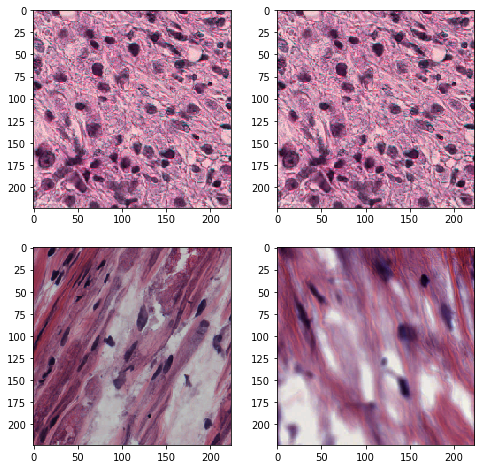

In [17]:
import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

n_patches = 5
images_per_batch = 130/n_patches
tile_size = (224,224) #TODO: Add to config

train_datagen = ImageDataGenerator(
    #rotation_range=10,
    #width_shift_range=0.07,
    #height_shift_range=0.07,
    brightness_range=(0.8,1.2), # 1.0 return a copy
    #fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True
    )

train_generator = BatchGenerator(
    train_dataset,
    batch_size=images_per_batch, 
    image_data_generator=train_datagen,
    should_augment_data=True,
    num_classes=num_classes,
    to_shuffle=True,
    dummy_reset=True, # if examples per epoch < num of samples, prevents repeat.
    n_patches=n_patches,
    reinhard_dict=reinhard_dict,
    norm_func=normalize_input,
    eq_modes=['eq_patches_by_slide'], #'eq_patches_by_label_v2'])
    patches_per_img=170)

test_generator = BatchGenerator(
    val_dataset, 
    batch_size=images_per_batch,
    should_augment_data=False,
    num_classes=num_classes,
    to_shuffle=False,
    dummy_reset=False, # Same test, every epoch. Even if epoch < num of samples
    n_patches=n_patches,
    norm_func=normalize_input,
    reinhard_dict=reinhard_dict,
    eq_modes=['eq_patches_by_slide'], #'eq_patches_by_label_v2'])
    patches_per_img=85)

test_generator_v2 = BatchGenerator(
    val_dataset, 
    batch_size=images_per_batch,
    should_augment_data=False,
    num_classes=num_classes,
    to_shuffle=False,
    dummy_reset=False, # Same test, every epoch. Even if epoch < num of samples
    n_patches=n_patches,
    reinhard_dict=reinhard_dict,
    norm_func=normalize_input,
    eq_modes=['eq_patches_by_patient_v5'], #'eq_patches_by_label_v2'])
    patches_per_img=170)

train_gen = ('Train eq by Slide', train_generator)
test_gens = [('Test eq by Slide' , test_generator)] #[ ('Test eq by Slide', test_generator), ('Test eq by Patient' , test_generator_v2) ]

%time __, X1, __, __ = test_generator.next()
test_generator.reset()
__, X2, __, __ = test_generator.next()
test_generator.reset()
%time __, X3, __, __ = train_generator.next()

print train_generator.num_classes, test_generator.num_classes

print X3.shape
print X1.shape

#Test
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(2,2,1)
plt.imshow(unormalize_input(X1[0,0]) / 255.0)
fig.add_subplot(2,2,2)
plt.imshow(unormalize_input(X2[0,0]) / 255.0)
#Train
fig.add_subplot(2,2,3)
plt.imshow(unormalize_input(X3[0,0]) / 255.0)
fig.add_subplot(2,2,4)
plt.imshow(unormalize_input(X3[0,1]) / 255.0)

#assert (X1[0] == X2[0]).all() 

input preprocess (224, 224, 3) (150528,)


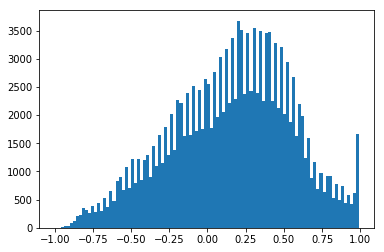

In [18]:
def flatten_and_plot_layer(name, out, clip=None):
    out_flat = np.reshape(out, (-1))
    print name, out.shape, out_flat.shape
    plt.hist(out_flat, bins=100, range=clip)
    plt.show()
    
flatten_and_plot_layer('input preprocess', X1[0,0])

Build model
-----------

In [19]:
import keras.backend as K
import matplotlib.pyplot as plt

def acc_msk_0(x_true, x_pred):
    """Calculate accuracy, ignore (mask) 0 labels"""

    none_zero_count = K.sum(x_true)

    def calc_acc():
        trade_index = K.tf.not_equal(K.tf.reduce_sum(x_true, axis=-1), 0 )

        ##remove predictions that are 0
        x_true_tradeable = K.tf.boolean_mask(x_true, trade_index)
        x_pred_tradeable = K.tf.boolean_mask(x_pred, trade_index)

        #print x_true_tradeable.shape

        accuracy = K.mean(K.equal(K.tf.argmax(x_true_tradeable,-1), K.tf.argmax(x_pred_tradeable,-1)))
                
        accuracy = K.tf.cast(accuracy, K.tf.float32)
        return accuracy

    #K.eval(accuracy) will cause InvalidArgumentError if none_zero_count==0, add tensorflow condition so it won't be evaluated
    final_acc = K.tf.cond(K.tf.less(none_zero_count, 1e-7), lambda: 0.0, calc_acc)

    #return K.tf.stack([none_zero_count, final_acc]) #K.tf.stack([final_acc]) #
    return K.tf.stack([final_acc])

def test_acc(true, pred):
    y_true = K.constant(np.array(true))
    y_pred = K.constant(np.array(pred))
    #print y_true.shape, y_pred.shape
    acc_tensor = acc_msk_0(y_true, y_pred)
    acc = K.eval(acc_tensor)
    #print acc
    return tuple(acc)

def assertres(expected, result):
    assert len(expected) == len(result)
    for a,b in zip(expected, result):
        assert abs(a-b) < 1e-07 # float compare requires epsilon

print 'Test 1' #(2, 50)
assertres( (.5,) , test_acc([[0, 1], [0,1], [0, 0]],  [[1, 0], [0,1],[0, 1]]) )
    
print 'Test 2' #(4, 75)
assertres( (.75,) , test_acc([ [[0, 0, 1],[0,0,1]], [[0,0,1],[0,0,1]], [[0,0, 0],[0,0,0]] ], [ [[1,0, 0],[0,0, 1]], [[0,0,1],[0,0,1]] ,[[0,0, 1],[0,0,1]] ]) )

print 'Test 3' #(5, 80)
assertres( (.8,) , test_acc([ [[0, 1],[0,1]], [[0,1],[0,1]], [[0, 0],[0,1]] ], [ [[1, 0],[0, 1]], [[0,1],[0,1]] ,[[0, 1],[0,1]] ]) )
    
print 'Test 4' #(0, 0) #(special edge case, very important test!)
assertres( (0,) , test_acc([[0, 0], [0,0], [0, 0]],  [[1, 0], [0,1],[0, 1]]) )

Test 1
Test 2
Test 3
Test 4


In [20]:
class BatchCounter(keras.layers.Layer):
        """Stateful metric example"""
        def __init__(self, name="batch_counter", **kwargs):
            super(BatchCounter, self).__init__(name=name, **kwargs)
            self.stateful = True
            self.batches = keras.backend.variable(value=0, dtype="float32")

        def reset_states(self):
            keras.backend.set_value(self.batches, 0)

        def __call__(self, y_true, y_pred):
            updates = [keras.backend.update_add(self.batches, keras.backend.variable(value=1, dtype="float32"))]
            self.add_update(updates)
            return self.batches

In [21]:
def loss(y_true, y_pred):
    loss = keras.losses.categorical_crossentropy(y_true, y_pred)
    return loss
    
def loss_msk_0(y_true, y_pred):
    '''Just another crossentropy'''
    loss = keras.losses.categorical_crossentropy(y_true, y_pred)
    mask = K.tf.reduce_sum(y_true, axis=-1) #K.tf.not_equal(K.tf.reduce_sum(y_true, axis=-1), 0 )
    loss_masked = loss * mask #loss_masked = K.tf.boolean_mask(loss, mask)
    return loss_masked
    
def test_loss(true, pred, loss_func):
    y_true = K.constant(np.array(true))
    y_pred = K.constant(np.array(pred))
    #print y_true.shape, y_pred.shape
    loss_tensor = loss_func(y_true, y_pred)
    loss = K.eval(loss_tensor)
    return loss


a = test_loss([[0, 1], [0,1]],  [[1, 0], [0,1]], loss)
b = test_loss([[0, 1], [0,1], [0, 0]],  [[1, 0], [0,1],[0, 1]], loss_msk_0)
assert np.sum(a) == np.sum(b)


a = test_loss([ [[0, 1],[0,1]], [[0,1],[0,1]] ], [ [[1, 0],[0, 1]], [[0,1],[0,1]] ],loss)
b = test_loss([ [[0,1]] ], [ [[0,1]] ],loss)
#print a.shape, b.shape
c = test_loss([ [[0, 1],[0,1]], [[0,1],[0,1]], [[0, 0],[0,1]] ], [ [[1, 0],[0, 1]], [[0,1],[0,1]] ,[[0, 1],[0,1]] ],loss_msk_0)
#print c.shape

assert np.sum(a) + np.sum(b) == np.sum(c)

Org==X_aug Equal: False
X_aug==X2_aug Equal: False
X_aug==X_aug Equal: True


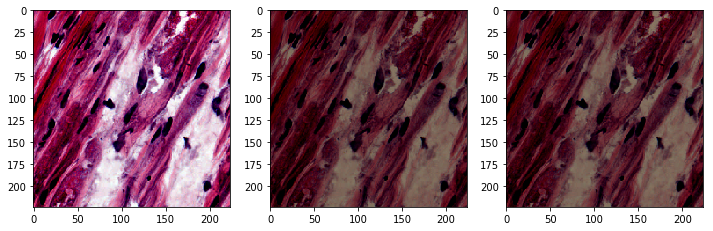

In [22]:
import numpy as np
from keras.engine.topology import Layer
import random


# For Usage in digits, add the following to the network protocol
# layer {
#   name: "augmentation_layer"
#   type: "Python"
#   bottom: "data"
#   top: "data"
#   python_param {
#     module: "digits_python_layers"
#     layer: "AugmentationLayer"
#     param_str: '{"rotate": True, "color": True, "color_a_min": .9, "color_a_max": 1.1, "color_b_min": -10, "color_b_max": 10}'
#   }
# }

def doRotation(imgs,args):
    #return np.rot90(imgs, random.randrange(4), axes=(1,2))
    import tensorflow as tf
    return tf.image.rot90( imgs, k=random.randrange(4))

def doColorAug(imgs,args):
    from keras import backend as K
    import tensorflow as tf
    # simple H&E color augmentation based on https://arxiv.org/pdf/1707.06183.pdf
    # Domain-adversarial neural networks to address the appearance variability of
    # histopathology images
    
    #NOTE, defaults assume data was stored as uint8 [0,255] . if data is stored as [0,1], scale accordingly

    pixel_depth = 255.0
    imgs = imgs * pixel_depth + pixel_depth /2
    #imgs = imgs * np.random.uniform(args["color_a_min"], args["color_a_max"], [1,3,1,1]) + np.random.uniform(args["color_b_min"], args["color_b_max"], [1,3,1,1])
    imgs = imgs * np.random.uniform(args["color_a_min"], args["color_a_max"], [1,1,1,3]) + np.random.uniform(args["color_b_min"], args["color_b_max"], [1,1,1,3])
    #imgs = imgs * tf.random_uniform([1,1,1,3], minval=args["color_a_min"], maxval=args["color_a_max"])+ tf.random_uniform([1,1,1,3], args["color_b_min"], args["color_b_max"])
    imgs = (imgs - pixel_depth / 2) / pixel_depth
    return imgs

def doAugmenttion(funcs,img):
    for func,args in funcs:
        img=func(img,args)
    return img

class AugmentationLayer(Layer):
    def __init__(self, rotate=False, color=False, color_a_min=.9,color_a_max=1.1,color_b_min=-10,color_b_max=10, **kwargs):
        super(AugmentationLayer, self).__init__(**kwargs)
        self.funcs= [] #create a list of augmentations to add
        colorArg={}
        

        if rotate: #check if we want rotational augmentation
            self.funcs.append((doRotation,None))
        if color:  #check if we want color augmentation
            colorArg["color_a_min"] = color_a_min #values pulled from paper
            colorArg["color_a_max"] = color_a_max
            colorArg["color_b_min"] = color_b_min
            colorArg["color_b_max"] = color_b_max
            self.funcs.append((doColorAug,colorArg))
            
        self.rotate = rotate
        self.color = color
        self.colorArg = colorArg

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {'rotate': self.rotate,
                  'color': self.color}
        config.update(self.colorArg)
        base_config = super(AugmentationLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs, training=None):
        if len(self.funcs) > 0:
            def aug_inputs():
                x = inputs
                for func, args in self.funcs:
                    x = func(x, args)
                return x
            #return K.in_train_phase(aug_inputs, inputs, training=training)
            return aug_inputs()
        return inputs

augLayer = AugmentationLayer(rotate=False, color=True, color_a_max=1.5, color_a_min=0.3)
X_aug = augLayer.call(np.array([X3[0,0]]),training=False) # True
X2_aug = augLayer.call(np.array([X3[0,0]]),training=True)
fig=plt.figure(figsize=(12, 8))
fig.add_subplot(1,3,1)
plt.imshow(X3[0,0]+0.5)
fig.add_subplot(1,3,2)
plt.imshow(X_aug[0]+0.5)
fig.add_subplot(1,3,3)
plt.imshow(X_aug[0]+0.5)
print 'Org==X_aug Equal: %s' % (X_aug[0] == X3[0,0]).all()
print 'X_aug==X2_aug Equal: %s' % (X_aug[0] == X2_aug[0]).all()
print 'X_aug==X_aug Equal: %s' % (X_aug[0] == X_aug[0]).all()

In [23]:
def make_one(tensor):
    tensor_comp = 1-tensor
    return K.concatenate([tensor, tensor_comp], axis=-1)

print K.eval(make_one(K.constant([[0.7], [0.5]])))

[[0.7 0.3]
 [0.5 0.5]]


In [24]:
from keras.layers import Reshape

class FullReshape(Reshape):
    """Like keras Reshape layer but doing reshape on the batch dimension as well.
        Same as doing Lambda(x : K.reshape(x, K.tf.stack(target_shape))), but lambda layers are fragile to save\load"""
    def __init__(self, target_shape, **kwargs):
        super(FullReshape, self).__init__(target_shape, **kwargs)
        self.trainable = False
    def compute_output_shape(self, input_shape):
        return super(FullReshape, self).compute_output_shape( (None,)+input_shape )[1:]
    def call(self, inputs):
        return K.reshape(inputs, K.tf.stack(self.target_shape))
    def get_config(self):
        #print 'ReshapeLayerConfig'
        return super(FullReshape, self).get_config()
class SumLayer(Layer):
    def __init__(self, axis, keep_dims=False, **kwargs):
        super(SumLayer, self).__init__(**kwargs)
        self.axis = axis
        self.keep_dims = keep_dims
        self.trainable = False
    def compute_output_shape(self, input_shape):
        ls = input_shape[:self.axis]
        if self.keep_dims:
            ls += (1,)
        ls += input_shape[self.axis+1:]
        return ls #K.tf.stack(ls)
    def call(self, inputs):
        return K.sum(inputs, axis=self.axis, keepdims=self.keep_dims)
    
    def get_config(self):
        #print 'SumLayerConfig'
        config = {'axis': self.axis, 'keep_dims':self.keep_dims}
        base_config = super(SumLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
class TileLayer(Layer):
    def __init__(self, multiples, **kwargs):
        super(TileLayer, self).__init__(**kwargs)
        self.multiples = multiples
        self.trainable = False

    def compute_output_shape(self, input_shape):
        ls = input_shape[0:1]
        for i, m in zip(input_shape[1:], self.multiples[1:]):
            ls += (i*m,)
        return ls

    def call(self, inputs, **kwargs):
        return K.tile(inputs, self.multiples)

    def get_config(self):
        # print 'SumLayerConfig'
        config = {'multiples': self.multiples}
        base_config = super(TileLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [25]:
%run 'AdamAccumulate.ipynb'

In [26]:
from keras.models import Sequential                                        
from keras.layers.core import Dense, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, MaxPooling1D, AveragePooling1D, Reshape, Lambda
from IPython.display import Image

num_classes = train_generator.num_classes

def relu6(x):
    return keras.backend.relu(x, max_value=6)

def norm_shape(shape):
        return tuple([int(shape[i].value or 0) for i in range(len(shape)) if i > 0])

def create_encoder(encoder_type, limit_layers=None, weights='imagenet'): # imagenet
    encoder_input = keras.layers.Input(shape=(tile_size[0], tile_size[1], 3))
    
    if encoder_type == 'InceptionV3':
        mob_model = keras.applications.inception_v3.InceptionV3(include_top=False, weights=weights, input_tensor=encoder_input)
    elif encoder_type == 'VGG16':
        mob_model = keras.applications.vgg16.VGG16(include_top=False, weights=weights, input_tensor=encoder_input)
    elif encoder_type == 'MobilenetV1':
        mob_model = keras.applications.mobilenet.MobileNet(weights=weights, include_top=False, input_tensor=encoder_input)#1e-3*drop_factor)
        #mob_model = keras.models.load_model('/var/shared/hist_project/Data/logs/mobilenet-balanced-1mpp-300frames/checkpoint_mobilenet_acc.h5', custom_objects={'relu6': relu6})

        mob_model.layers.pop()
    elif encoder_type == 'MobilenetV2':
        mob_model = keras.applications.mobilenetv2.MobileNetV2(weights='imagenet', include_top=False, input_tensor=encoder_input)#1e-3*drop_factor)

        mob_model.layers.pop()
    else:
        raise Error('Unknown encoder type %s' % encoder_type)
        
    if limit_layers is not None:
        mob_model = keras.models.Model(mob_model.input, mob_model.layers[limit_layers].output)
        
    mob_model_out = mob_model.layers[-1].output
    #mob_model_out = keras.layers.GlobalAveragePooling2D()(mob_model_out)
    
    #mob_model_out = Dense(100, input_shape=norm_shape(mob_model_out.shape))(mob_model_out)
    #mob_model_out = BatchNormalization()(mob_model_out)
    #mob_model_out = Activation('tanh')(mob_model_out)
    
    return keras.models.Model(inputs = encoder_input, outputs=mob_model_out, name='Encoder')    

def create_encoder_2():
    def conv_block(x, filters, kernel_size, repeat):
        for i in range(repeat):
            x = Conv2D(filters, kernel_size, padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
        x = MaxPooling2D(pool_size = (2, 2), strides=(2, 2))(x)
        return x
    
    encoder_input = keras.layers.Input(shape=(tile_size[0], tile_size[1], 3))
    x = conv_block(encoder_input, 64, (3, 3), repeat=2)
    x = conv_block(x, 128, (3, 3), repeat=2)
    x = conv_block(x, 256, (3, 3), repeat=2)
    
    return keras.models.Model(inputs=encoder_input, outputs=x, name='Encoder')

def create_encoder_3():
    from vis.utils import utils
    import keras.backend as K
    import keras
    import re

    encoder_input = keras.layers.Input(shape=(224, 224, 3))
    mob_model = keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_tensor=encoder_input)

    selected_out_layers = []
    for i in range(16):
        layer_name = 'block_%d_project_BN' % (i + 1)
        layer_idx = utils.find_layer_idx(mob_model, layer_name)
        selected_out_layers.append(mob_model.layers[layer_idx])

    max_size = selected_out_layers[0].output.shape[1:3]
    min_size = selected_out_layers[-1].output.shape[1:3]

    selected_outs = []
    for i in range(15):
        cur_shape = selected_out_layers[i].output.shape[1:3]
        factor = tuple([int(max_size[j]) / int(cur_shape[j]) for j in range(2)])
        lamb = TileLayer(multiples=tuple([1, factor[0], factor[1], 1]))
        outi = lamb(selected_out_layers[i].output)

        selected_outs.append(outi)

    mass_concat = keras.layers.Concatenate()(selected_outs)

    print mass_concat.shape

    mob_model_out = Dense(100, input_shape=norm_shape(mass_concat.shape))(mass_concat)
    mob_model_out = BatchNormalization()(mob_model_out)
    mob_model_out = Activation('tanh')(mob_model_out)

    largest_factor = tuple([int(m1)/int(m2) for m1,m2 in zip(max_size, min_size)])
    mob_model_out = Conv2D(filters=100, kernel_size=largest_factor, strides=largest_factor)(mob_model_out)
    print mob_model_out.shape

    encoder = keras.models.Model(inputs=encoder_input, outputs=mob_model_out, name='Encoder')

    #print mob_model_out.shape
    #print encoder.compute_output_shape((None, 224, 224, 3))
    #print encoder.output.shape
    #assert mob_model_out.shape == encoder.compute_output_shape((None, 224, 224, 3)) == encoder.output.shape
    for layer in encoder.layers[:-6]:
        layer.trainable = False
    
    return encoder
    
def create_model(n_patches, tile_size, num_classes, problem_cols, encoder_type, limit_layers=None):
    def reduce_mul(iterable):
        import operator
        return reduce(operator.mul, iterable, 1)
    
    """New"""
    model_input = keras.layers.Input(shape=(None, tile_size[0], tile_size[1], 3))

    #n_patches = shape = K.shape(model_input)[1] # Tensor
    
    input_flat = FullReshape((-1, tile_size[0], tile_size[1], 3))(model_input)
    print input_flat.shape, len(input_flat.shape)
    #print 'A', Lambda(lambda x : K.reshape(x, K.tf.stack([-1, tile_size[0], tile_size[1], 3]))).compute_output_shape(model_input)
    
    #encoder = create_encoder_3()
    encoder = create_encoder(encoder_type, limit_layers)
    
    #encoder.trainable= False # Freeze encoder
    #for layer in encoder.layers[:-3]:
    #    layer.trainable = False
    
    print encoder.compute_output_shape(input_flat.shape)
    encoder_out = encoder(input_flat)
    
    encoder_out_shape = norm_shape(encoder_out.shape) #(7, 7, 1024)
    print encoder_out_shape
    encoder_size = encoder_out_shape[-1]
    roi_count = reduce_mul(e for e in encoder_out_shape[:-1])
    print encoder_size, roi_count, [-1, n_patches*roi_count, encoder_size]
    encoder_restacked = FullReshape((-1, n_patches*roi_count, encoder_size))(encoder_out)
    
    print 'C', encoder_restacked.shape, type(encoder_restacked.shape)
    #(-1, 49*3, 1290)
    
    #mob_model_out = Lambda(lambda x: K.reshape(x, K.tf.stack([-1, n_patches, final_layer_size])))(encoder_out)
    #print mob_model_out.shape

    fc_layers = () #('PrimarySite', 'Sample_type', 'ER_Status', 'Cancer_type')
    max_layers = set(problem_cols) #('Differentiated')

    out_layer_names = []
    out_layers = []
    for class_size, prob_col in zip(num_classes, problem_cols):
        layer_name = prob_col + '_Layer'
        
        patch_att_probs_tan = Dense(1, input_shape=norm_shape(encoder_restacked.shape))(encoder_restacked)
        patch_att_probs_tan = keras.layers.BatchNormalization()(patch_att_probs_tan)
        patch_att_probs_tan = keras.layers.Activation('tanh',name='%s_att_probs_tan'%prob_col)(patch_att_probs_tan)
        #(-1, 49*3, 1)
        patch_att_probs = keras.layers.Softmax(axis=1)(patch_att_probs_tan)
        
        # sigmoid
        patch_sigmoid = Dense(1, input_shape=norm_shape(encoder_restacked.shape))(encoder_restacked)
        patch_sigmoid = keras.layers.BatchNormalization()(patch_sigmoid)
        patch_sigmoid = keras.layers.Activation('sigmoid',name='%s_patch_sigmoid' % prob_col)(patch_sigmoid)
        #(-1, 49*3, 1)
        
        patch_att_mul = keras.layers.Multiply()([patch_att_probs, patch_sigmoid])
        #(-1, 49*3, 1)
        print patch_att_mul.shape, type( patch_att_mul.shape)
        all_final_prob = SumLayer(axis=1,keep_dims=True)(patch_att_mul)
        print all_final_prob.shape
        #(-1, 1, 1)
        
        layer = Lambda(lambda x: make_one(x), name=layer_name)(all_final_prob)
        
        out_layer_names.append(layer_name)
        out_layers.append(layer)

    print out_layers
    model = keras.models.Model(inputs=model_input,outputs=out_layers)
    optimizer = keras.optimizers.Adam(amsgrad=True)
    #optimizer = AdamAccumulate(lr=0.0001 ,amsgrad=True, accum_iters=10)
    #loss = 'categorical_crossentropy'
    model.compile(loss=loss_msk_0, 
              optimizer=optimizer, 
              metrics={l_name:acc_msk_0 for l_name in out_layer_names},
              #weighted_metrics={l_name:'categorical_accuracy' for l_name in out_layer_names},
              #weighted_metrics={'PrimarySite_Layer':'acc'},
              #loss_weights={l_name: 1.0 if l_name in ('PrimarySite_Layer') else 0.0 for l_name in out_layer_names},
              #loss_weights={'PrimarySite_Layer': 1.0},
              sample_weight_mode='temporal',
             )
    
    return encoder, model

encoder, model = create_model(n_patches, tile_size, num_classes, problem_cols, encoder_type='MobilenetV2',limit_layers=None)#'MobilenetV1')

logs_dir = config.logs_dir
if not os.path.isdir(logs_dir):
    os.mkdir(logs_dir)

print encoder.summary()

print model.summary()

print 'model created'

(?, 224, 224, 3) 4


/var/shared/miniconda2/envs/histo/lib/python2.7/site-packages/keras_applications/mobilenet_v2.py:310: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


(Dimension(None), Dimension(7), Dimension(7), 1280)
(7, 7, 1280)
1280 49 [-1, 245, 1280]
C (?, 245, 1280) <class 'tensorflow.python.framework.tensor_shape.TensorShape'>
(?, 245, 1) <class 'tensorflow.python.framework.tensor_shape.TensorShape'>
(?, 1, 1)
[<tf.Tensor 'ER_Status_Layer/concat:0' shape=(?, 1, 2) dtype=float32>]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]     

In [27]:
#acc_optimizer = AdamAccumulate(lr=0.001 ,amsgrad=True, accum_iters=4)
#model.compile(loss=loss_msk_0, 
#              optimizer=acc_optimizer, 
#              metrics={l_name:acc_msk_0 for l_name in ['ER_Status_Layer']},
#              sample_weight_mode='temporal',
#             )

In [28]:
def freeze_encoder(model, layer_name_exclusive=None):
    import vis
    from vis.utils import utils
    encoder_layer_idx = utils.find_layer_idx(model, 'Encoder')
    encoder = model.layers[encoder_layer_idx]
    if layer_name_exclusive:
        layer_freeze_exclusive_idx = utils.find_layer_idx(encoder, layer_name_exclusive)
        for layer in encoder.layers[:layer_freeze_exclusive_idx]:
            layer.trainable = False
        for layer in encoder.layers[layer_freeze_exclusive_idx:]:
            layer.trainable = True
    else:
        encoder.trainable=False

freeze_encoder(model, 'block_14_expand')

#model.set_weights(old_model.get_weights())
#model.layers[2].trainable = False

model.compile(loss=loss_msk_0, 
              optimizer= keras.optimizers.Adam(amsgrad=True), 
              metrics={(l_name+'_Layer'):acc_msk_0 for l_name in problem_cols},
              sample_weight_mode='temporal',
             )
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 224, 22 0                                            
__________________________________________________________________________________________________
full_reshape_1 (FullReshape)    (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Encoder (Model)                 (None, 7, 7, 1280)   2257984     full_reshape_1[0][0]             
__________________________________________________________________________________________________
full_reshape_2 (FullReshape)    (None, 245, 1280)    0           Encoder[1][0]                    
__________________________________________________________________________________________________
dense_1 (D

In [ ]:
import thread

print 'Testing save\load'
print 'Saving...',
model.save(logs_dir+"/test.h5")
print 'passed'
print 'Loading...',
model = keras.models.load_model(logs_dir+"/test.h5", 
                                custom_objects={'relu6': relu6, 'acc_msk_0':acc_msk_0, 
                                'loss_msk_0':loss_msk_0, 'make_one':make_one, 
                                'FullReshape':FullReshape, 'SumLayer':SumLayer})
print 'passed'

Testing save\load
Saving... passed
Loading...

In [29]:
# To get learning rate
from keras import backend as K
lr = K.get_value(model.optimizer.lr)
print(lr)
# To set learning rate
#K.set_value(model.optimizer.lr, lr*2)
print(K.get_value(model.optimizer.lr))

0.001
0.001


Run
---

In [30]:
#model.stateful_metric_names = [l_name for l_name in out_layer_names]
print model.stateful_metric_names
print model.loss_weights

[]
None


In [31]:
import os
import collections

class DomainHistoryCallback(keras.callbacks.CSVLogger):
    """Domain History logger"""
    """Skips Group ImageReaders, requires basename method in ImageReader"""
    def __init__(self, problems, class_dicts, csv_filename, sep=',', append=False):
        self.problems = tuple(problems)
        self.class_dicts = class_dicts
        assert len(problems) == len(class_dicts)
        
        super(DomainHistoryCallback, self).__init__(csv_filename, sep, append)
    def on_epoch_begin(self, epoch, logs={}):
        self.domain_tracker = {}
    def on_batch_end(self, batch, logs={}):
        X_names, Y = logs['batch_trace'], logs['batch_labels']
        dataset_type = logs['dataset_type']
        for domain_id, (p_all, y_all) in enumerate(zip(logs['batch_preds'], Y)):
            p_all, y_all = np.squeeze(p_all), np.squeeze(y_all)
            for img_reader, pi, yi in zip(X_names, p_all, y_all):
                if not getattr(img_reader, "basename", None):
                    continue # skip group image readers
                if sum(yi) == 0:
                    continue # skip 0 labels
                y_idx = np.argmax(yi)
                p_idx = np.argmax(pi)
                key = img_reader, dataset_type
                if key not in self.domain_tracker:
                    self.domain_tracker[key] = {}
                if domain_id not in self.domain_tracker[key]:
                    self.domain_tracker[key][domain_id] = {'y_idx':y_idx, 'good': 0, 'total': 0}
                assert y_idx == self.domain_tracker[key][domain_id]['y_idx'] #constistency
                self.domain_tracker[key][domain_id]['good'] += int(y_idx==p_idx)
                self.domain_tracker[key][domain_id]['total'] += 1 
    def on_epoch_end(self, epoch , logs={}):
        class_dicts_inv = np.array([{(v-1):k for k,v in d.iteritems() if v!=0}  for d in self.class_dicts])
        sorted_keys = sorted(self.domain_tracker.keys(), key=lambda (img_reader,__) : img_reader.basename())
        for key in sorted_keys:
            img_reader, dataset_type = key
            row = collections.OrderedDict()
            row['Patient'] = img_reader.barcode()
            slide_name = img_reader.basename()
            row['Slide' ] = slide_name[:slide_name.index('.')]
            row['frames'] = img_reader.n_frames()
            row['Dataset'] = dataset_type
            for domain in self.problems:
                row[domain+'_acc'] = row[domain+'_total'] = row[domain] = None
            for domain_id, domain_results in self.domain_tracker[key].iteritems():
                domain_name = self.problems[domain_id]
                row[domain_name] = class_dicts_inv[domain_id][domain_results['y_idx']]
                row[domain_name+'_acc'] = 1.0 * domain_results['good'] / domain_results['total']
                row[domain_name+'_total'] = domain_results['total']
            super(DomainHistoryCallback, self).on_epoch_end(epoch, row)

In [32]:
import pickle
import numpy as np
import sys
import datetime

total_in_train = train_gen[1].num_examples
total_in_tests = [gen.num_examples for __,gen in test_gens]
#class_weights = train_generator.weights

minimal_exp = False
exp_name = 'exp_mobilenetv2_0.6mpp_5patches_sigmoid_att_cnn_new_er_eq_slidev3_dx_bn_preprocv2_reinhard_freezeenc_block14-'
if minimal_exp:
    exp_name = 'min_' + exp_name
    print '-----------Minimal experiment----------'

start_epoch = 0
    
csv_logger_callback = keras.callbacks.CSVLogger(logs_dir+'/%s.log' % exp_name, append=True)
lr_decay = keras.callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * (0.97 ** epoch))
val_checkpoint_callback = keras.callbacks.ModelCheckpoint(logs_dir+"/%s_val_e%d.h5" % (exp_name, start_epoch), 
                                      monitor='val1_loss', verbose=1, save_best_only=True, mode='min')
acc_checkpoint_callback = keras.callbacks.ModelCheckpoint(logs_dir+"/%s_acc_e%d.h5" % (exp_name, start_epoch), 
                                      monitor='val1_acc_msk_0', verbose=1, save_best_only=True, mode='max')
error_logger_callback = DomainHistoryCallback(problem_cols, get_label_dicts(),logs_dir+'/%s.csv' % exp_name, append=True)

print 'total in train: %d' % total_in_train
print 'total in test: %s' % str(total_in_tests)

if minimal_exp:
    s = 15000, 6000
else:
    s = 100000, 60000

steps_in_train = s[0]/images_per_batch/n_patches
steps_in_tests = [min(s[1],total_in_test)/images_per_batch for total_in_test in total_in_tests]
print 'steps in train: %d' % steps_in_train
print 'steps in test: %s' % str(steps_in_tests) 

#print train_generator.weights

class StateFullMetric():
    def __init__(self):
        self.is_init = False
    def on_batch_end(self, outs, batch_none_zero_counts):
        assert len(outs) == len(batch_none_zero_counts)
        length = len(outs)
        if not self.is_init:
            self.values = np.array([.0]*length)
            self.none_zero_counts = np.array([1e-6]*length)
            self.is_init = True
        else:
            assert len(self.values) == length
        for i in range(length):
            self.values[i] = (outs[i]*batch_none_zero_counts[i] + self.values[i] * self.none_zero_counts[i])/(batch_none_zero_counts[i]+self.none_zero_counts[i])
            self.none_zero_counts[i] = batch_none_zero_counts[i]+self.none_zero_counts[i]
    def vals(self):
        return self.values
    def reset_states(self):
        self.is_init = False
        
def gen_mask(Y):
    prob_count = len(Y) #'order of outs is loss, [all prob losses], [all prob acc]' (if one problem-> [all prob losses no])
    none_zero_counts = np.array([np.sum(y) for y in Y])
    assert len(none_zero_counts) == prob_count
    mask_list = [np.array([sum(none_zero_counts)]), none_zero_counts]
    if prob_count > 1:
        mask_list.append(none_zero_counts)
    final_mask = np.concatenate(mask_list)
    #print final_mask
    return final_mask

def make_epoch_logs(outs, metric_names):
    import collections
    epoch_logs = collections.OrderedDict()
    for i, out in enumerate(outs):
        prefix = ''
        if i > 0:
            prefix += 'val%d_' % i # test
        for o, name in zip(out, metric_names):
            epoch_logs[prefix+name] = o
    return epoch_logs

def make_batch_logs(loss, batch_trace, batch_labels, batch_preds, dataset_type):
    return {'loss': loss, 'batch_trace' : batch_trace, 'batch_labels':batch_labels, 'batch_preds':batch_preds, 'dataset_type':dataset_type}

def make_status_line(step, num_steps, outs, metric_names, start_epoch_time):
    import math
    prog_prec = int(math.ceil(1.0 * step / num_steps * 100 / 3.333))
    
    current_time = datetime.datetime.now()
    delta = current_time - start_epoch_time
    eta = (delta / (step+1) * (num_steps-step-1))

    s = '   %d/%d [%-30s] - ETA: %s ' % (step, num_steps, '='*prog_prec, eta)
    epoch_logs = make_epoch_logs(outs, metric_names)
    for key,value in epoch_logs.iteritems():
        s += ' - %s: %.4f' % (key, value)
    sys.stdout.write('\r')
    sys.stdout.write(s)
    sys.stdout.flush()
def reset_model_metrics(model):
    #model.reset_states()
    for met in model.metrics.values():
        if isinstance(met, Layer):
           met.reset_states()
    #print model.metrics, type(model.metrics[0])
def normalize_model(model):
    """predictions are needed for Domain history callback"""
    if 'predictions' not in model.metrics_names:
        model.train_function = None
        model.test_function = None
        model.metrics_tensors += model.outputs
        model.metrics_names += ['predictions']
def run_generator(model, generator, callbacks, stateful_metric, total_steps, is_train, domain_type, last_out_history=[]):
    start_epoch_time = datetime.datetime.now()
    model.stop_training = not is_train
    batch_out = None
    generator.reset()
    stateful_metric.reset_states()
    for step in range(total_steps):
        x_trace, x, y, __ = generator.next()
        x_names = [t[0] for t in x_trace]
        if is_train:
            batch_out = model.train_on_batch(x, y)
        else:
            batch_out = model.test_on_batch(x, y)
        num_probs = len(generator.num_classes)
        batch_out, batch_pred = batch_out[:-num_probs], batch_out[-num_probs:]
        #update domain history
        batch_logs = make_batch_logs(batch_out[0], x_names, y, batch_pred, domain_type)
        for c in callbacks:
            c.on_batch_end(step, batch_logs)
        #update metrics & status bar
        stateful_metric.on_batch_end(batch_out, gen_mask(y))
        batch_out = stateful_metric.vals()
        make_status_line(step, total_steps, last_out_history + [batch_out], model.metrics_names, start_epoch_time)
    return batch_out
    
normalize_model(model)
    
callbacks = [csv_logger_callback, lr_decay,  val_checkpoint_callback, acc_checkpoint_callback, error_logger_callback]

for c in callbacks:
    c.set_model(model)
    c.on_train_begin()

stateful_metric = StateFullMetric()
    
print model.metrics_names
epoches = 120
for e in range(start_epoch, epoches):
    print 'Epoch %d/%d' % (e+1, epoches)
    for c in callbacks:
        c.on_epoch_begin(e)
    
    train_batch_out = run_generator(model, train_gen[1], callbacks, stateful_metric, steps_in_train, True, train_gen[0], [])
    
    last_out_history = [train_batch_out]
    for steps_in_test, (test_gen_domain, test_gen) in zip(steps_in_tests, test_gens):
        test_batch_out = run_generator(model, test_gen, callbacks, stateful_metric, steps_in_test, False, test_gen_domain, last_out_history)
        last_out_history.append(test_batch_out)

    print ''
    for c in callbacks:
        c.on_epoch_end(e, make_epoch_logs([train_batch_out, test_batch_out], model.metrics_names))

#model.save(logs_dir+"/tissue_mobilenetv2.h5")

total in train: 634650
total in test: [24171]
steps in train: 769
steps in test: [929]
['loss', 'acc_msk_0', 'predictions']
Epoch 1/120
   924/929 [==============================] - ETA: 0:00:08.628968  - loss: 0.5458 - acc_msk_0: 0.7341 - val1_loss: 0.6091 - val1_acc_msk_0: 0.6742

/var/shared/miniconda2/envs/histo/lib/python2.7/site-packages/histomicstk-0.2.0-py2.7-linux-x86_64.egg/histomicstk/preprocessing/color_normalization/reinhard.py:83: RuntimeWarning: invalid value encountered in divide
  im_lab[:, :, i] = im_lab[:, :, i] / src_sigma[i]
/var/shared/miniconda2/envs/histo/lib/python2.7/site-packages/histomicstk-0.2.0-py2.7-linux-x86_64.egg/histomicstk/preprocessing/color_normalization/reinhard.py:91: RuntimeWarning: invalid value encountered in greater
  im_normalized[im_normalized > 255] = 255
/var/shared/miniconda2/envs/histo/lib/python2.7/site-packages/histomicstk-0.2.0-py2.7-linux-x86_64.egg/histomicstk/preprocessing/color_normalization/reinhard.py:92: RuntimeWarning: invalid value encountered in less
  im_normalized[im_normalized < 0] = 0


   928/929 [==============================] - ETA: 0:00:00  - loss: 0.5458 - acc_msk_0: 0.7341 - val1_loss: 0.6088 - val1_acc_msk_0: 0.6746 0.6744

Epoch 00001: val1_loss improved from inf to 0.60878, saving model to /var/shared/hist_project/Data/logs/exp_mobilenetv2_0.6mpp_5patches_sigmoid_att_cnn_new_er_eq_slidev3_dx_bn_preprocv2_reinhard_freezeenc_block14-_val_e0.h5

Epoch 00001: val1_acc_msk_0 improved from -inf to 0.67463, saving model to /var/shared/hist_project/Data/logs/exp_mobilenetv2_0.6mpp_5patches_sigmoid_att_cnn_new_er_eq_slidev3_dx_bn_preprocv2_reinhard_freezeenc_block14-_acc_e0.h5
Epoch 2/120
   928/929 [==============================] - ETA: 0:00:00  - loss: 0.5038 - acc_msk_0: 0.7593 - val1_loss: 0.5529 - val1_acc_msk_0: 0.7214 0.7214

Epoch 00002: val1_loss improved from 0.60878 to 0.55289, saving model to /var/shared/hist_project/Data/logs/exp_mobilenetv2_0.6mpp_5patches_sigmoid_att_cnn_new_er_eq_slidev3_dx_bn_preprocv2_reinhard_freezeenc_block14-_val_e0.h5

Epoch 00

Epoch 25/120
   928/929 [==============================] - ETA: 0:00:00  - loss: 0.3707 - acc_msk_0: 0.8486 - val1_loss: 0.5492 - val1_acc_msk_0: 0.7198 0.7198

Epoch 00025: val1_loss did not improve from 0.53817

Epoch 00025: val1_acc_msk_0 did not improve from 0.73226
Epoch 26/120
   928/929 [==============================] - ETA: 0:00:00  - loss: 0.3715 - acc_msk_0: 0.8487 - val1_loss: 0.5653 - val1_acc_msk_0: 0.7099 0.7100

Epoch 00026: val1_loss did not improve from 0.53817

Epoch 00026: val1_acc_msk_0 did not improve from 0.73226
Epoch 27/120
   928/929 [==============================] - ETA: 0:00:00  - loss: 0.3661 - acc_msk_0: 0.8528 - val1_loss: 0.5756 - val1_acc_msk_0: 0.7030 0.7030

Epoch 00027: val1_loss did not improve from 0.53817

Epoch 00027: val1_acc_msk_0 did not improve from 0.73226
Epoch 28/120
   928/929 [==============================] - ETA: 0:00:00  - loss: 0.3630 - acc_msk_0: 0.8527 - val1_loss: 0.6007 - val1_acc_msk_0: 0.6972 0.6972

Epoch 00028: val1_loss did

Epoch 53/120
   928/929 [==============================] - ETA: 0:00:00  - loss: 0.3259 - acc_msk_0: 0.8760 - val1_loss: 0.5517 - val1_acc_msk_0: 0.7217 0.7218

Epoch 00053: val1_loss did not improve from 0.51985

Epoch 00053: val1_acc_msk_0 did not improve from 0.74422
Epoch 54/120
   928/929 [==============================] - ETA: 0:00:00  - loss: 0.3236 - acc_msk_0: 0.8766 - val1_loss: 0.5431 - val1_acc_msk_0: 0.7306 0.7308

Epoch 00054: val1_loss did not improve from 0.51985

Epoch 00054: val1_acc_msk_0 did not improve from 0.74422
Epoch 55/120
   928/929 [==============================] - ETA: 0:00:00  - loss: 0.3274 - acc_msk_0: 0.8731 - val1_loss: 0.5819 - val1_acc_msk_0: 0.7050 0.7051

Epoch 00055: val1_loss did not improve from 0.51985

Epoch 00055: val1_acc_msk_0 did not improve from 0.74422
Epoch 56/120
   928/929 [==============================] - ETA: 0:00:00  - loss: 0.3220 - acc_msk_0: 0.8804 - val1_loss: 0.5474 - val1_acc_msk_0: 0.7236 0.7237

Epoch 00056: val1_loss did

Epoch 83/120
   928/929 [==============================] - ETA: 0:00:00  - loss: 0.3077 - acc_msk_0: 0.8906 - val1_loss: 0.5589 - val1_acc_msk_0: 0.7161 0.7163

Epoch 00083: val1_loss did not improve from 0.51985

Epoch 00083: val1_acc_msk_0 did not improve from 0.74422
Epoch 84/120
   928/929 [==============================] - ETA: 0:00:00  - loss: 0.3086 - acc_msk_0: 0.8889 - val1_loss: 0.5684 - val1_acc_msk_0: 0.7104 0.7105

Epoch 00084: val1_loss did not improve from 0.51985

Epoch 00084: val1_acc_msk_0 did not improve from 0.74422
Epoch 85/120
   928/929 [==============================] - ETA: 0:00:00  - loss: 0.3100 - acc_msk_0: 0.8869 - val1_loss: 0.5543 - val1_acc_msk_0: 0.7185 0.7187

Epoch 00085: val1_loss did not improve from 0.51985

Epoch 00085: val1_acc_msk_0 did not improve from 0.74422
Epoch 86/120
   928/929 [==============================] - ETA: 0:00:00  - loss: 0.3040 - acc_msk_0: 0.8902 - val1_loss: 0.5611 - val1_acc_msk_0: 0.7150 0.7151

Epoch 00086: val1_loss did

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/var/shared/miniconda2/envs/histo/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/var/shared/miniconda2/envs/histo/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/var/shared/miniconda2/envs/histo/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/var/shared/miniconda2/envs/histo/lib/python2.7/inspect.py", line 1051, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/var/shared/miniconda2/envs/histo/lib/python2.7/inspect.py", line 1011, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/var/shared/miniconda2/envs/histo/lib/python2.7/inspect.py", line 453, in getsourcefile

IndexError: string index out of range

In [36]:
model.save(logs_dir+"/[epoch_%d]%s.h5" % (39, exp_name))
#model.save_weights(logs_dir+"/last_model_unify_3_mobilenet_3patches_er_pr_her2.weights")

def relu6(x):
    return keras.backend.relu(x, max_value=6)

#checkpoint_file = '[epoch_24]cont_model_mobilenet_4patches_new_er_pr_her2fish_her2ihc_her2ihcscore_eq_patient_v7.2_dx.h5'
#checkpoint_file = '[epoch_18]paper_mobilenet_2patches_new_er_eq_slidev2_nodx.h5'
#model = keras.models.load_model(logs_dir+"/"+checkpoint_file, 
#                                custom_objects={'relu6': relu6, 'acc_msk_0':acc_msk_0, 'loss_msk_0':loss_msk_0})

In [ ]:
target_epoch = 18
#target_steps_in_test = steps_in_test
target_steps_in_test = total_in_test/images_per_batch#/n_patches

error_logger_callback = DomainHistoryCallback(problem_cols, get_label_dicts(),logs_dir+'/%s.csv' % exp_name, append=True)
error_logger_callback.set_model(model)
error_logger_callback.on_train_begin()

test_generator.reset()
model.stop_training = True
start_epoch_time = datetime.datetime.now()
error_logger_callback.on_epoch_begin(0)
for step_test in range(target_steps_in_test):
    x_trace, x, y, __ = test_generator.next()
    x_names = [t[0] for t in x_trace]
    y_pred = model.predict_on_batch(x)
    if len(test_generator.num_classes) == 1:
        y_pred = [y_pred]
    batch_logs = {'batch_trace':x_names, 'batch_labels': y, 'batch_preds': y_pred}
    error_logger_callback.on_batch_end(step_test, batch_logs)
    make_status_line(step_test, target_steps_in_test, [], model.metrics_names, start_epoch_time)
print ''

error_logger_callback.domain_tracker = error_logger_callback.domain_tracker
error_logger_callback.on_epoch_end(target_epoch)
print 'Done'

In [ ]:
#model = keras.models.load_model(logs_dir+"/test.h5", 
#                                custom_objects={'relu6': relu6, 'acc_msk_0':acc_msk_0, 'Acc_Msk_0':Acc_Msk_0})

#[method_name for method_name in dir(model2) if callable(getattr(model2, method_name))] # Print methods

#model_weights_path = logs_dir + '/last_model_unify_3_mobilenet_3patches_er_pr_her2.weights'
prob_to_test = problem_cols #['Cancer_type', 'ER_Status', 'PR_Status', 'PrimarySite']
prob_to_test.sort()
#model = create_model(3, (224, 224), (8, 2, 2, 2, 15, 2), prob_to_test)
#model.load_weights(model_weights_path)

In [ ]:
print type(t), len(t), t[0].shape, t[1].shape, t[2].shape
print type(y), len(y), y[0].shape, y[1].shape, y[2].shape

In [39]:
train_data.loc[~train_data.PrimarySite.isin(grade_sites), 'Differentiated'] = 'UNK'
def prepare_gtex_data():
    import os
    labels_folder = '/var/shared/zelda-gtex/Tissues'
    data_folder = '/var/shared/zelda-gtex/1mpp-patches/GTEX'
    gtex_tissues = os.listdir(labels_folder)
    #tissue_labels = [for os.path.walkdir()]
    #print gtex_tissues
    gtex_to_tcga_label = {'MammaryTissueBreast':'Breast'} #{'Ectocervix':'Cervix', 'Endocervix': 'Cervix'} # 'Lung':'Lung', 
    gtex_tissues = [g for g in gtex_tissues if g in gtex_to_tcga_label]
    #print gtex_tissues
    gtex_labels_dict = {}
    for gtex_label in gtex_tissues:
        for filename in os.listdir(labels_folder+"/"+gtex_label):
            gtex_labels_dict[filename[:-4]] = gtex_to_tcga_label[gtex_label]
    #print gtex_labels
    
    diff_dict, site_label_dict, sample_type_dict = get_label_dicts()

    gtex_filenames = [] 
    gtex_labels = []
    for filename in os.listdir(data_folder):
        if filename in gtex_labels_dict:
            gtex_filenames.append(data_folder+'/'+filename)
            gtex_labels.append((diff_dict['well']-1, site_label_dict[gtex_labels_dict[filename]]-1, sample_type_dict['Normal']-1))
            
    return np.array(gtex_filenames), np.array(gtex_labels)
gtex_data, gtex_labels = prepare_gtex_data()

print gtex_data.shape, gtex_labels.shape

NameError: name 'train_data' is not defined

In [42]:
n_patches = 4

class EvalGenerator(object):
    def __init__(self, dataset, batch_size, patches_per_sample):        
        self.data = dataset
        self.batch_size = batch_size
        self.patches_per_sample = patches_per_sample
        self.reset()
    def reset(self):
        self.batch_start = 0
    def __iter__(self):
        return self
    def __next__(self):
        def load_image_file(image_path):
            img = ImageReader.open(image_path, type='png')
            if not img.exists(): #TEMPORARY
                return [], []
            n_frames = img.n_frames() / n_patches * n_patches
            frames = []
            frame_ids = random.sample(range(n_frames), min(n_frames,self.patches_per_sample))
            for i in frame_ids:
                frames.append(img.load_frame(i))
            return chunks(frame_ids, n_patches), chunks(frames, n_patches)
        def normalize_input(X):
            pixel_depth = 255.0
            return (X - pixel_depth / 2) / pixel_depth
        
        total = len(self.data[0])
                
        if self.batch_start == total:
            raise StopIteration
        batch_end = min(total, self.batch_start + self.batch_size)
        
        images, labels = self.data
        images, labels = images[self.batch_start:batch_end], labels[self.batch_start:batch_end]
        #labels = labels[:,self.target_class_index]
                
        X = []
        Y = []
        Z = []
        T = []
        for i, (image_path, label) in enumerate(zip(images, labels)):
            image_name = os.path.basename(image_path)
            X_subframe_ids, X_subframes = load_image_file(image_path)
            X.extend(zip(X_subframe_ids, X_subframes))
            Y.extend([label] * len(X_subframes))
            Z.extend([self.batch_start+i] * len(X_subframes)) # slide number
            T.append(image_name) # Image name
        
        batch_frame_ids, batch_frames = zip(*X)
        batch_frame_ids, batch_frames = np.array(batch_frame_ids), np.array(batch_frames)
        batch_frames = normalize_input(batch_frames)
        
        X = batch_frame_ids, batch_frames
        Y = np.array(Y)
        Z = np.array(Z)
        T = np.array(T, dtype=object)
        
        self.batch_start = batch_end
        return X, Y, Z, T

    next = __next__  # Python 2 compatibility

def predict_model(model, dataset, batch_size, patches_per_sample):
    from itertools import groupby
    
    eval_gen = EvalGenerator(dataset, batch_size=batch_size, patches_per_sample=patches_per_sample)
    
    predict_dict = {}
    
    eval_gen.reset()
    for i, (X,Y,Z,T) in enumerate(eval_gen):
        
        batch_frame_ids, batch_frames = X
        prediction = model.predict(batch_frames, batch_size=350)
        prediction = [np.squeeze(p, 1) for p in prediction]
        #prediction = prediction[target_class_index]
        batch_predict_labels = tuple([np.argmax(p, axis=-1) for p in prediction])
        batch_real_labels = Y
        
        print 'batch %d' % i
        slide_name_itr = iter(T)
        
        # Z must be sorted to call groupby (it is)
        for k, g in groupby(zip(zip(*batch_predict_labels),batch_real_labels,batch_frame_ids,Z), lambda t:t[3]):
            slide_name = slide_name_itr.next()
            
            g_list = list(g)
            
            g_predict,g_label,g_frame,__ = zip(*g_list) # last element in every tuple is slide num
            
            predict_dict[slide_name] = (g_predict,g_label,g_frame)
            
    return predict_dict
    
def majority_vote(model_prediction):
    
    real_labels = []
    predict_labels = []
    
    for slide_name, slide_prediction in model_prediction.iteritems():
        g_predict,g_label,g_frame = slide_prediction
            
        num_probs = len(g_predict[0])
        #assert (np.array(g_predict).shape == np.array(g_label).shape)
        real_counter, predict_majort = [], []
        predict_major = [Counter(np.array(g_predict)[:,i]).most_common(1)[0][0] for i in range(num_probs)]
        real_counter = [Counter(np.array(g_label)[:,i]) for i in range(num_probs)]
        for i in range(num_probs):
            assert len(real_counter[i]) == 1 # against bugs
        real_major = [r.most_common(1)[0][0] for r in real_counter]
              
        #print real_major, predict_major, g_predict # DEBUG
                
        real_labels.append(real_major)
        predict_labels.append(predict_major)
    
    
    return predict_labels, real_labels 

def calc_accuracy(predictions, labels):
    acc_list = []
    num_probs = len(predictions[0])
    for i in range(num_probs):
        none_zero_correct_count = len([1 for p,r in zip(predictions, labels) if p[i]==r[i]-1 and r[i]!=0])
        none_zero_count = len([1 for l in labels if l[i] != 0])
        acc_list.append(none_zero_correct_count / float(none_zero_count))
    return acc_list

def calc_accuracy_per_class(predictions, labels):
    correct_dict = {}
    total_dict = {}
    for p,l in zip(predictions,labels):
        if p == l:
            correct_dict[l] = correct_dict.get(l, 0) + 1
        total_dict[l] = total_dict.get(l, 0) + 1
    accuracy_dict = {l:(correct_dict.get(l, 0)/float(total_dict[l])) for l in total_dict.keys()}
    accuracy_absolute_dict = {l:"{}/{}".format(correct_dict.get(l,0), total_dict[l]) for l in total_dict.keys()}
    return accuracy_dict, accuracy_absolute_dict

#prediction_dict = predict_model(model, (val_dataset[0][:100], val_dataset[1][:100]), batch_size=10, patches_per_sample=50)
prediction_dict = predict_model(model, (val_dataset[0], val_dataset[1]), batch_size=10, patches_per_sample=50)
predictions, labels = majority_vote(prediction_dict)

#print predictions, labels
acc = calc_accuracy(predictions, labels)
prob_to_test.sort()
assert len(prob_to_test) == len(acc)
for prob, acc_i in zip(prob_to_test, acc):
    print '%s acc: %f' % (prob, acc_i)
#print('acc per class: %s' % str(calc_accuracy_per_class(predictions,labels)))

batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 49
batch 50
batch 51
batch 52
batch 53
batch 54
batch 55
batch 56
batch 57
batch 58
batch 59
batch 60
batch 61
batch 62
batch 63
batch 64
batch 65
batch 66
batch 67
batch 68
batch 69
batch 70
batch 71
batch 72
batch 73
batch 74
batch 75
batch 76
batch 77
batch 78
batch 79
batch 80
batch 81
batch 82
batch 83
batch 84
batch 85
batch 86
batch 87
batch 88
batch 89
batch 90
batch 91
batch 92
batch 93
batch 94
batch 95
batch 96
batch 97
batch 98
batch 99
batch 100
batch 101
batch 102
batch 103
batch 104
batch 105
batch 106
batch 107
batch 108
batch 109
batch 110


Cancer_type acc: 0.781437 <br/>
ER_Status acc: 0.845070 <br/>
HER2_Final_Status acc: 0.732394 <br/>
PR_Status acc: 0.633803 <br/>
PrimarySite acc: 0.909651 <br/>
Sample_type acc: 0.949533

In [128]:
# Constant?
#class_dict = {'CESC': 14, 'SKCM': 10, 'LUSC': 9, 'READ': 15, 'OV': 16, 'LIHC': 3, 'GBM': 1, 'LGG': 0, 'HNSC': 17, 'STAD': 2, 'UCEC': 12, 'PRAD': 13, 'LUAD': 6, 'KIRC': 4, 'BRCA': 8, 'COAD': 5, 'THCA': 18, 'KIRP': 7, 'BLCA': 11}
class_dict = get_label_dicts()

train_data,train_labels = train_dataset
train_names = [os.path.basename(image_path) for image_path in train_data]
train = {name:l for name,l in zip(train_names, train_labels)}

# Write predictions to file
prediction_file = '/var/shared/hist_project/Data/logs/[epoch_%d]%s.predictions' % (28, exp_name)
out_dict = {'class_dict': class_dict, 'predictions_dict': prediction_dict, 'train':train, 'probs': prob_to_test,
           'predictions': predictions, 'labels':labels}

with open(prediction_file, 'wb+') as f:
        pickle.dump(out_dict, f, pickle.HIGHEST_PROTOCOL)

In [24]:
# LGG - Brain Lower Grade Glioma
# GBM - Glioblastoma multiforme
# KIRC - Kidney renal clear cell carcinoma
# BRCA - Breast invasive carcinoma
# UCEC - Uterine Corpus Endometrial Carcinoma

In [129]:
# Error analysis
print prob_to_test
print class_dict
print predictions[:3]
print labels[:3]
print len(predictions), len(val_dataset[0])

['Cancer_type', 'ER_Status', 'HER2_Final_Status', 'PrimarySite']
[{'KIRC': 8, 'GBM': 4, 'LUAD': 6, 'LUSC': 1, 'READ': 2, 'COAD': 7, 'KIRP': 3, 'UNK': 0, 'LGG': 5}, {'Positive': 1, 'UNK': 0, 'Negative': 2}, {'Positive': 1, 'UNK': 0, 'Negative': 2}, {'Thyroid': 14, 'Cervix': 3, 'Stomach': 13, 'Bladder': 1, 'Brain': 5, 'Head and Neck': 6, 'Lung': 9, 'Breast': 2, 'Colorectal': 4, 'Skin': 12, 'Uterus': 15, 'Ovary': 10, 'UNK': 0, 'Prostate': 11, 'Kidney': 7, 'Liver': 8}]
[[6, 0, 0, 3], [6, 0, 0, 12], [6, 0, 0, 10]]
[[2, 0, 0, 4], [0, 0, 0, 13], [0, 0, 0, 11]]
1461 1461


In [130]:
for slide_path, pred, l in zip(val_dataset[0], predictions, labels):
    print slide_path, pred, l
    break

/var/shared/hist_project/Data/Level2/TCGA/TCGA-B3-3926-11A-01-BS1.b91513a6-eb9e-46a5-9826-0330e0585640 [6, 0, 0, 3] [2, 0, 0, 4]


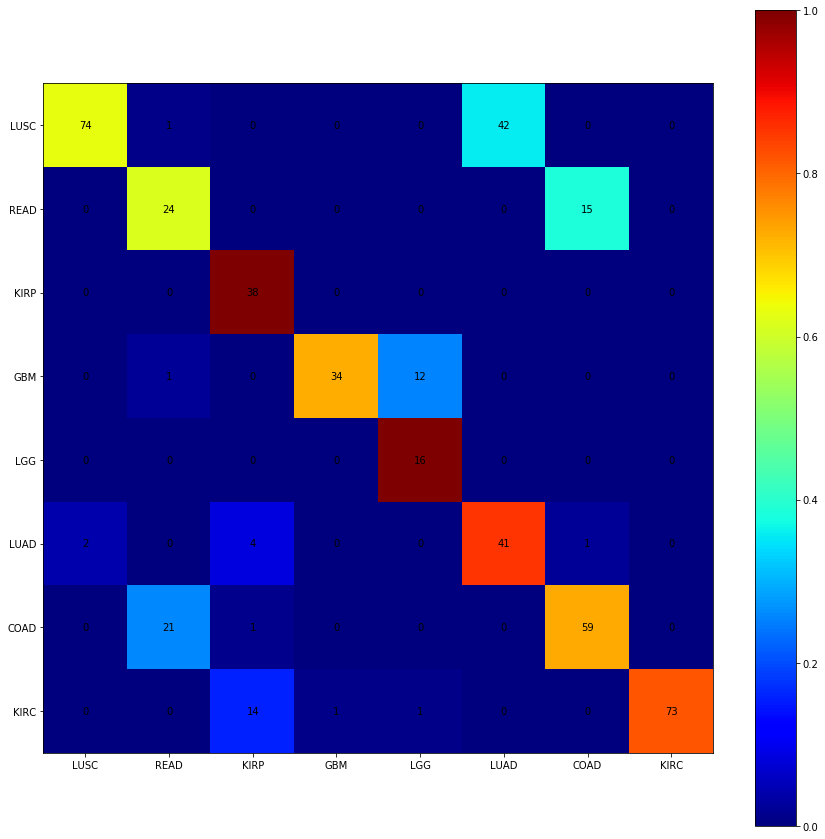

In [142]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def calc_confusion_matrix(predictions, labels, index):
    flatten = lambda l: [item for sublist in l for item in sublist]

    filter_idx = set([i for i, l in enumerate(labels) if l[index] != 0])
    
    real_labels_flat = [p[index] for i, p in enumerate(predictions) if i in filter_idx]
    predict_labels_flat = [l[index]-1 for i, l in enumerate(labels) if i in filter_idx]
    return confusion_matrix(real_labels_flat, predict_labels_flat)

def plot_confusion_matrix(class_dicts, predictions, labels, index):
    conf_arr = calc_confusion_matrix(predictions, labels, index)
    class_dict = {key:(value-1) for key, value in class_dicts[index].iteritems() if value > 0}
    
    norm_conf = []
    for i in conf_arr:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)

    fig = plt.figure(figsize=(15, 15))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                    interpolation='nearest')

    width, height = conf_arr.shape

    for x in xrange(width):
        for y in xrange(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')

    class_arr = sorted(class_dict, key=class_dict.get)
            
    cb = fig.colorbar(res)
    alphabet = class_arr  #'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    plt.xticks(range(width), alphabet[:width])
    plt.yticks(range(height), alphabet[:height])
    #plt.savefig('confusion_matrix.png', format='png')
    
prob_index = np.argwhere(np.array(prob_to_test) == 'Cancer_type')[0][0]
plot_confusion_matrix(class_dict, predictions, labels, prob_index)

In [57]:
conf_mat = calc_confusion_matrix(predictions, labels, 3)
conf_mat.shape

(15, 15)

In [61]:
sum(conf_mat[:,0])

111

In [65]:
print len([1 for l in labels if l[3]==1])

111


In [84]:
def calc_acc_per_class(predictions, labels, index, class_dicts):
    
    class_dict = class_dicts[index]
    class_dict_inverse = {v:k for k,v in class_dict.iteritems()}

    filter_idx = set([i for i, l in enumerate(labels) if l[index] != 0])
    
    pred_filtered = [p[index] for i, p in enumerate(predictions) if i in filter_idx]
    label_filtered = [l[index]-1 for i, l in enumerate(labels) if i in filter_idx]
    
    total_total = 0
    total_correct = 0
    
    acc_dict = {}
    for i in range(len(class_dict)-1):
        if i == 0:
            continue
        i -= 1
        total = sum([1 for l in label_filtered if l==i])
        correct = sum([1 for p,l in zip(pred_filtered,label_filtered) if l==i and p==l])
        acc_dict[class_dict_inverse[i+1]] = (1.0 * correct / total, total)
        
        total_total += total
        total_correct += correct
    
    for k,v in acc_dict.iteritems():
        print '%s : %.3f (%d)' % (k,v[0], v[1])
    print '\nTotal acc: %.3f' % (1.0*total_correct/total_total)
    
calc_acc_per_class(predictions, labels, 3, class_dict)

Thyroid : 0.782 (119)
Cervix : 0.025 (81)
Stomach : 0.631 (160)
Bladder : 0.108 (111)
Brain : 0.821 (117)
Head and Neck : 0.542 (96)
Lung : 0.657 (198)
Breast : 0.851 (181)
Colorectal : 0.772 (162)
Skin : 0.667 (75)
Ovary : 0.931 (144)
Prostate : 0.897 (136)
Kidney : 0.657 (169)
Liver : 0.683 (139)

Total acc: 0.676


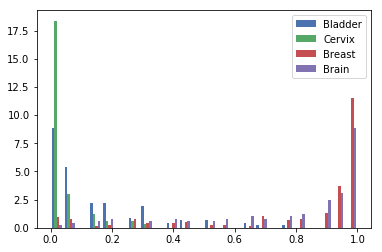

In [305]:
def plot_class_error_distribution(prediction_dict, (x, y), index, class_dicts, sub_class_name):
    from matplotlib.pyplot import hist
    class_dict = class_dicts[index]
    class_dict_inverse = {v:k for k,v in class_dict.iteritems()}
    
    sub_class_index = class_dict[sub_class_name] - 1
    
    slides_arr = []
    acc_arr = []
    
    for slide_path, label in zip(x,y):
        l = label[index] - 1
        if l != sub_class_index:
            continue
            
        slide_name = os.path.basename(slide_path)
        #print prediction_dict[slide_name][2]
        correct = sum([1 for p in prediction_dict[slide_name][0] if p[index]==sub_class_index])
        total = len(prediction_dict[slide_name][0])
        acc = 1.0 * correct / total
        
        slides_arr.append(slide_name)
        acc_arr.append(acc)
    
    return slides_arr, acc_arr
    
sub_classes = ['Bladder', 'Cervix', 'Breast', 'Brain'] #['Bladder', 'Brain', 'Breast', 'Lung']
slides_arr, acc_arr = zip(*[plot_class_error_distribution(prediction_dict, val_dataset, 3, class_dict, c) for c in sub_classes])
assert len(slides_arr) == len(acc_arr) == len(sub_classes)

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

bins = np.linspace(0, 1, 25)

plt.hist(acc_arr, bins, label=sub_classes, density=True)
plt.legend(loc='upper right')
plt.show()

In [306]:
def extract_full_barcode(img_name):
    return img_name[:findnth(img_name,'.',0)]
def extract_patient(barcode):
    return barcode[:findnth(barcode,'-',2)]
def slice_by_classes(Y, num_classes):
            slice_start = 0
            slices = []
            for n in num_classes:
                slice_end = slice_start + n
                slices.append(slice(slice_start, slice_end, 1))
                slice_start = slice_end
            #print slices

            return [Y[s] for s in slices]
def extract_dx_prec_from_gen(gen,class_dicts, class_index, sub_class_name):
    train_frames = [[extract_full_barcode(os.path.basename(patient_reader.find_img_reader(f_id)[0].path)) for f_id in frames] for (patient_reader, frames),label,__ in zip(*gen.data) if np.argmax(slice_by_classes(label,num_classes)[class_index])==class_dicts[class_index][sub_class_name]-1]
    train_frames = flatten(train_frames)
    
    print len(train_frames), len(set(train_frames))

    dx_frame_count = sum([1 for slide_name in train_frames if 'DX' in slide_name])
    total_frame_count = len(train_frames)
    return 1.0 * dx_frame_count / total_frame_count

"""
print len(slides_arr), len(acc_arr)
test_slides_acc = [(extract_full_barcode(slide),acc) for slide, acc in zip(slides_arr,acc_arr)]
test_slides = [slide for slide,acc in test_slides_acc]
good_slides = [slide for slide, acc in test_slides_acc if acc > 0.8]
bad_slides = [slide for slide, acc in test_slides_acc if acc < 0.2]
print len(good_slides), len(bad_slides)
"""

for sub_class_name in sub_classes:
    dx_prec_train = extract_dx_prec_from_gen(train_generator2, class_dict, 3, sub_class_name)
    dx_prec_test = extract_dx_prec_from_gen(test_generator, class_dict, 3, sub_class_name)

    print 'Train DX in %s: %.3f' % (sub_class_name, dx_prec_train)
    print 'Test DX in %s: %.3f' % (sub_class_name, dx_prec_test)

1012248 12560
246648 735
Train DX in Bladder: 0.404
Test DX in Bladder: 0.373
133386 516
29772 81
Train DX in Cervix: 0.446
Test DX in Cervix: 0.480
133404 2914
29772 181
Train DX in Breast: 0.405
Test DX in Breast: 0.273
133209 3446
29772 117
Train DX in Brain: 0.385
Test DX in Brain: 0.458


In [247]:
print 1.0 * sum([1*train_patient_dx_weight[extract_patient(slide_name)] for slide_name in train_slides if 'DX' in slide_name]) / (len(train_slides)+1e-6)
print 1.0 * sum([1*test_patient_dx_weight[extract_patient(slide_name)] for slide_name in good_slides if 'DX' in slide_name]) / (len(good_slides)+1e-6)
print 1.0 * sum([1*test_patient_dx_weight[extract_patient(slide_name)] for slide_name in bad_slides if 'DX' in slide_name]) / (len(bad_slides)+1e-6)

0.27868915146
0.0606164375258
0.0158536581499


In [213]:
# TCGA-TSS-Participant-Sample-Portion-Loc
print good_slides[:5]
print bad_slides[:5]

['TCGA-BF-A1PX-01A-01-TSA', 'TCGA-D3-A2J7-06Z-00-DX1', 'TCGA-3N-A9WD-01Z-00-DX1', 'TCGA-D3-A1QB-06A-01-TSA', 'TCGA-BF-A1PZ-01A-01-TSA']
['TCGA-D3-A1QA-07A-01-TSA', 'TCGA-D3-A1Q4-06Z-00-DX1', 'TCGA-BF-AAP1-01Z-00-DX1', 'TCGA-BF-AAOU-01A-01-TS1', 'TCGA-BF-A5EP-01Z-00-DX1']


In [214]:
from collections import Counter

def get_tss(img_name):
    return img_name[findnth(img_name,'-',0)+1:findnth(img_name,'-',1)]
def norm_counter(counter):
    total = sum(counter.values(), 0.0)
    return {k:'%.3f' %(v/total) for k,v in counter.iteritems()}

good_tss = norm_counter(Counter([get_tss(slide_name) for slide_name in good_slides]))
bad_tss = norm_counter(Counter([get_tss(slide_name) for slide_name in bad_slides]))


print good_tss
print bad_tss

{'BF': '0.700', 'D3': '0.200', '3N': '0.100'}
{'BF': '0.588', 'D3': '0.412'}
